In [105]:
from stable_baselines3 import TD3
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
from typing import TYPE_CHECKING, Any, Callable, Optional, Union
from stable_baselines3.common.vec_env import DummyVecEnv, VecEnv, sync_envs_normalization
from stable_baselines3.common.logger import Logger
import gymnasium as gym
from gym.wrappers import RecordVideo
import numpy as np
import os
import matplotlib.pyplot as plt

np.bool8 = np.bool_

In [111]:
#training timesteps
training = 12000
rec_no = 300
video_save_freq = 3000
models_saved = [rec_no * i for i in range(1,int(training/rec_no)+1)]
print(models_saved)
# Setup
save_path = "./checkpoints/"
videos = []
for i in models_saved:
    if i % video_save_freq == 0:
        videos.append(i)
print(videos)


[300, 600, 900, 1200, 1500, 1800, 2100, 2400, 2700, 3000, 3300, 3600, 3900, 4200, 4500, 4800, 5100, 5400, 5700, 6000, 6300, 6600, 6900, 7200, 7500, 7800, 8100, 8400, 8700, 9000, 9300, 9600, 9900, 10200, 10500, 10800, 11100, 11400, 11700, 12000]
[3000, 6000, 9000, 12000]


In [112]:
class SaveOnStepCallback(BaseCallback):
    def __init__(self, save_freq: int, save_path: str, verbose: int = 0):
        super(SaveOnStepCallback, self).__init__(verbose)
        self.save_freq = save_freq
        self.save_path = save_path
        os.makedirs(save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.num_timesteps % self.save_freq == 0:
            save_file = os.path.join(self.save_path, f"model_step_{self.num_timesteps}")
            self.model.save(save_file)
        return True

In [113]:
# Dictionary to track the highest reward for each timestep
highest_reward_per_timestep = {y: -np.inf for y in models_saved}
best_trajectory_per_timestep = {}
best_model_per_timestep = {}
best_env_seed_per_timestep = {}
best_actions = {}
callback = SaveOnStepCallback(save_freq=rec_no, save_path=save_path)

runs = 10
avg_rewards = []
for run in range(0,runs):
    print("Run", run)
    run_list = []
           
    # Load the environment and model
    env = gym.make("InvertedPendulum-v4", render_mode="rgb_array")  # Render for visualization
    
    n_actions = env.action_space.shape[-1]
    
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
    model = TD3("MlpPolicy", env, action_noise=action_noise)
    #model.batch_size = int(64)
    #model.learning_rate = 10**(-2.5)
    model = model.learn(training,callback = callback)

    for y in models_saved:
        c_seed=np.random.randint(0, 10000)
        obs, info = env.reset(seed=c_seed)  # Random seed for reproducibility
    
        done = False
        total_episode_reward = 0
        trajectory = []
        actions = []
        checkpoint_path = f"./checkpoints/model_step_{y}.zip"
        loaded_model = TD3.load(checkpoint_path)
        while not done:
            # Predict action using the trained model
            action, _ = loaded_model.predict(obs, deterministic=True)
    
            actions.append(action)
    
            # Take the action in the environment
            obs, reward, done,truncated, info = env.step(action)
            
            # Collect data
            trajectory.append((obs, action, reward))
            total_episode_reward += reward
        #print("ran",y)
        actions = np.array(actions)
        run_list.append(total_episode_reward)
        
        # Check if this is the highest reward for the current training timestep
        if total_episode_reward > highest_reward_per_timestep[y]:
            #print(f"New highest reward for {y} timesteps: {total_episode_reward} (previous: {highest_reward_per_timestep[y]})")
            highest_reward_per_timestep[y] = total_episode_reward
            best_trajectory_per_timestep[y] = trajectory  # Save the best trajectory
            best_model_per_timestep[y] = loaded_model  # Save the model for video recording
            best_env_seed_per_timestep[y] = c_seed  # Save the environment seed
            best_actions[y] = actions 
            # Specify the directory and filename
            save_dir = f"./checkpoints/best_models/timesteps_{training}"
            os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
            save_path = os.path.join(save_dir, f"{y}_timesteps_best_model.zip")
            
            # Save the model
            model.save(save_path)
            if y == models_saved[-1]:
               print(highest_reward_per_timestep)
                
    env.close()
    avg_rewards.append(run_list)    
    # Specify the directory you want to clean up
    directory = "./checkpoints"
    
    # Iterate through the files in the directory
    for filename in os.listdir(directory):
        # Check if the file is a zip file
        if filename.endswith(".zip"):
            file_path = os.path.join(directory, filename)
            # Remove the file
            os.remove(file_path)
    del model 
    del env
print("done!")



Run 0
{300: 3.0, 600: 3.0, 900: 3.0, 1200: 6.0, 1500: 45.0, 1800: 38.0, 2100: 38.0, 2400: 56.0, 2700: 97.0, 3000: 65.0, 3300: 59.0, 3600: 76.0, 3900: 72.0, 4200: 136.0, 4500: 60.0, 4800: 73.0, 5100: 67.0, 5400: 77.0, 5700: 77.0, 6000: 180.0, 6300: 120.0, 6600: 112.0, 6900: 113.0, 7200: 108.0, 7500: 121.0, 7800: 156.0, 8100: 113.0, 8400: 114.0, 8700: 123.0, 9000: 85.0, 9300: 88.0, 9600: 87.0, 9900: 87.0, 10200: 101.0, 10500: 80.0, 10800: 81.0, 11100: 80.0, 11400: 76.0, 11700: 91.0, 12000: 90.0}
Run 1
{300: 3.0, 600: 3.0, 900: 37.0, 1200: 11.0, 1500: 45.0, 1800: 44.0, 2100: 43.0, 2400: 56.0, 2700: 97.0, 3000: 65.0, 3300: 59.0, 3600: 76.0, 3900: 72.0, 4200: 136.0, 4500: 60.0, 4800: 73.0, 5100: 67.0, 5400: 77.0, 5700: 77.0, 6000: 180.0, 6300: 120.0, 6600: 112.0, 6900: 113.0, 7200: 108.0, 7500: 121.0, 7800: 156.0, 8100: 113.0, 8400: 114.0, 8700: 123.0, 9000: 85.0, 9300: 88.0, 9600: 87.0, 9900: 87.0, 10200: 101.0, 10500: 103.0, 10800: 81.0, 11100: 80.0, 11400: 83.0, 11700: 101.0, 12000: 116.

In [114]:
# Specify the directory you want to clean up
directory = "./checkpoints"
# Iterate through the files in the directory
for filename in os.listdir(directory):
# Check if the file is a zip file
    if filename.endswith(".zip"):
        file_path = os.path.join(directory, filename)
        # Remove the file
        os.remove(file_path)

Recording video for the best episode with 3000 timesteps (reward: 89.0)


C:\Users\Indum\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at C:\Users\Indum\Documents\Year4\Reinforcement_Learning\Lab\Coursework2\stable-baselines3-master\videos\best\timesteps_12000\timesteps_3000 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


MoviePy - Building video C:\Users\Indum\Documents\Year4\Reinforcement_Learning\Lab\Coursework2\stable-baselines3-master\videos\best\timesteps_12000\timesteps_3000\eval_best_run-episode-0.mp4.
MoviePy - Writing video C:\Users\Indum\Documents\Year4\Reinforcement_Learning\Lab\Coursework2\stable-baselines3-master\videos\best\timesteps_12000\timesteps_3000\eval_best_run-episode-0.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\Indum\Documents\Year4\Reinforcement_Learning\Lab\Coursework2\stable-baselines3-master\videos\best\timesteps_12000\timesteps_3000\eval_best_run-episode-0.mp4


C:\Users\Indum\AppData\Local\Temp\ipykernel_18704\4003856502.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 5))  # Optional: set figure size


Recording video for the best episode with 6000 timesteps (reward: 191.0)
MoviePy - Building video C:\Users\Indum\Documents\Year4\Reinforcement_Learning\Lab\Coursework2\stable-baselines3-master\videos\best\timesteps_12000\timesteps_6000\eval_best_run-episode-0.mp4.
MoviePy - Writing video C:\Users\Indum\Documents\Year4\Reinforcement_Learning\Lab\Coursework2\stable-baselines3-master\videos\best\timesteps_12000\timesteps_6000\eval_best_run-episode-0.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\Indum\Documents\Year4\Reinforcement_Learning\Lab\Coursework2\stable-baselines3-master\videos\best\timesteps_12000\timesteps_6000\eval_best_run-episode-0.mp4
Recording video for the best episode with 9000 timesteps (reward: 128.0)


C:\Users\Indum\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at C:\Users\Indum\Documents\Year4\Reinforcement_Learning\Lab\Coursework2\stable-baselines3-master\videos\best\timesteps_12000\timesteps_9000 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


MoviePy - Building video C:\Users\Indum\Documents\Year4\Reinforcement_Learning\Lab\Coursework2\stable-baselines3-master\videos\best\timesteps_12000\timesteps_9000\eval_best_run-episode-0.mp4.
MoviePy - Writing video C:\Users\Indum\Documents\Year4\Reinforcement_Learning\Lab\Coursework2\stable-baselines3-master\videos\best\timesteps_12000\timesteps_9000\eval_best_run-episode-0.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\Indum\Documents\Year4\Reinforcement_Learning\Lab\Coursework2\stable-baselines3-master\videos\best\timesteps_12000\timesteps_9000\eval_best_run-episode-0.mp4
Recording video for the best episode with 12000 timesteps (reward: 242.0)
MoviePy - Building video C:\Users\Indum\Documents\Year4\Reinforcement_Learning\Lab\Coursework2\stable-baselines3-master\videos\best\timesteps_12000\timesteps_12000\eval_best_run-episode-0.mp4.
MoviePy - Writing video C:\Users\Indum\Documents\Year4\Reinforcement_Learning\Lab\Coursework2\stable-baselines3-master\videos\best\timesteps_12000\timesteps_12000\eval_best_run-episode-0.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\Indum\Documents\Year4\Reinforcement_Learning\Lab\Coursework2\stable-baselines3-master\videos\best\timesteps_12000\timesteps_12000\eval_best_run-episode-0.mp4


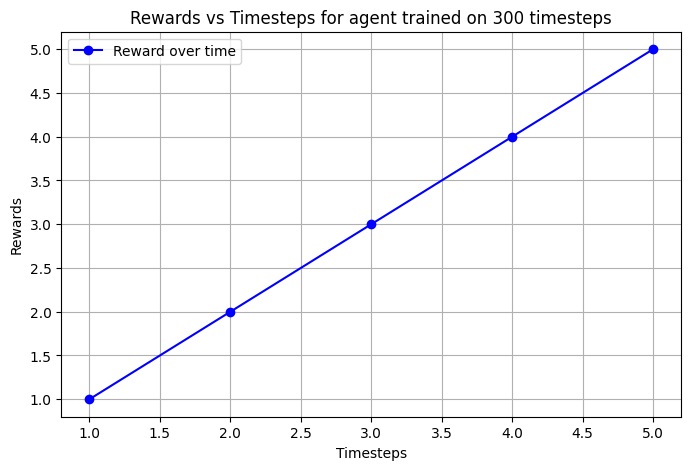

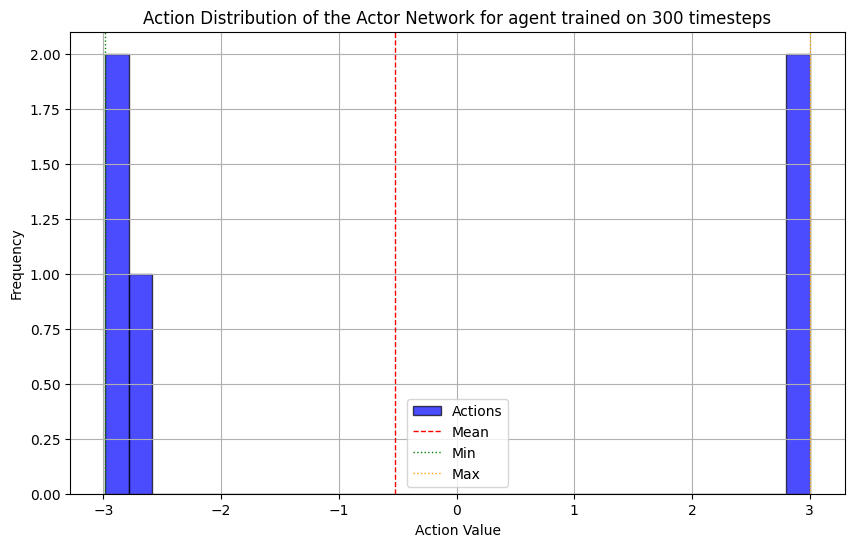

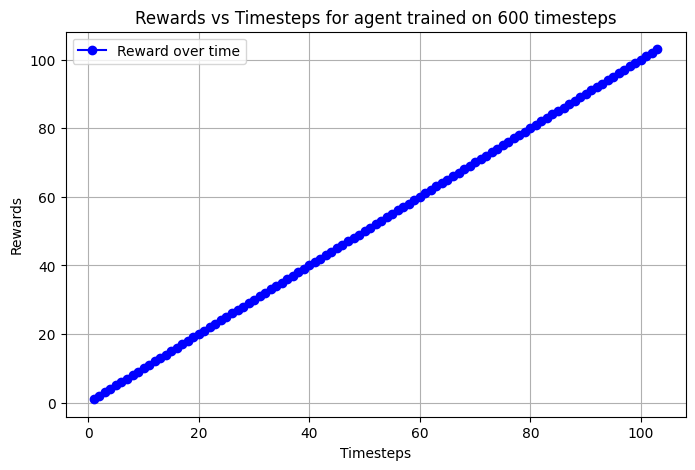

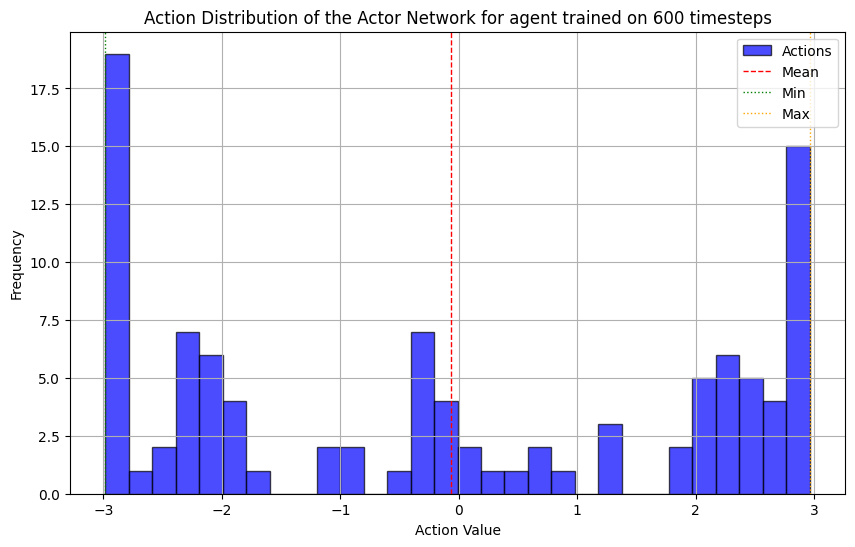

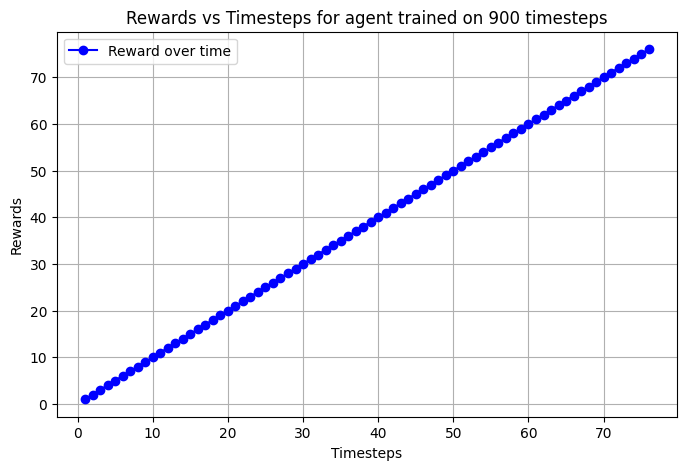

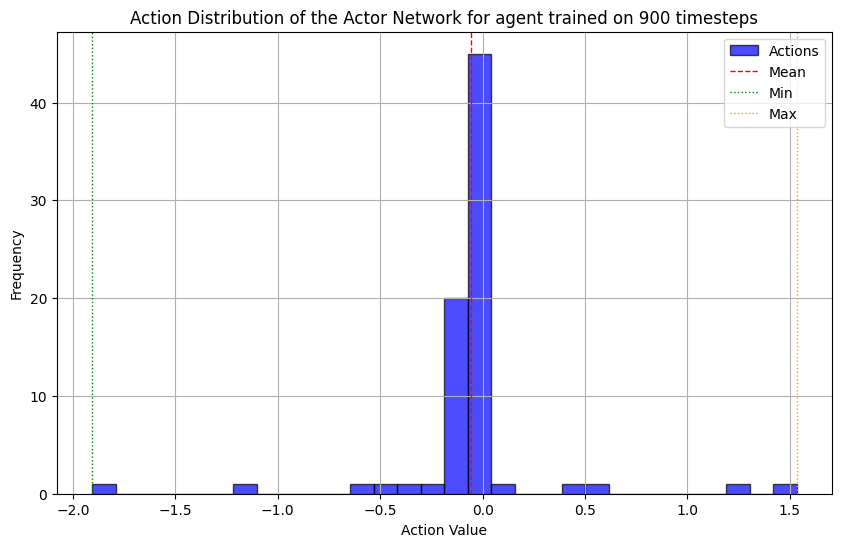

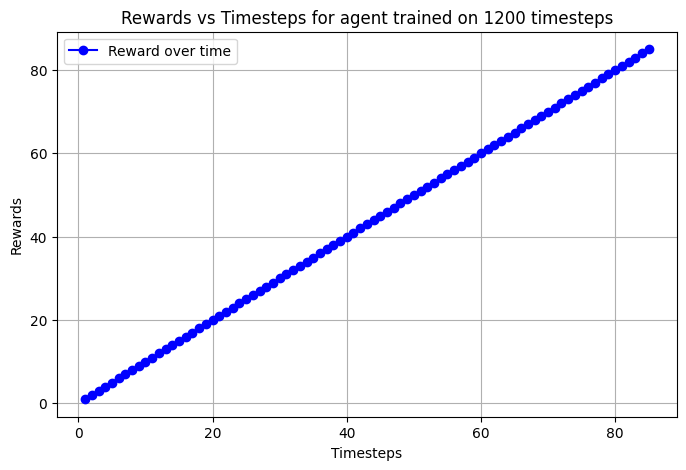

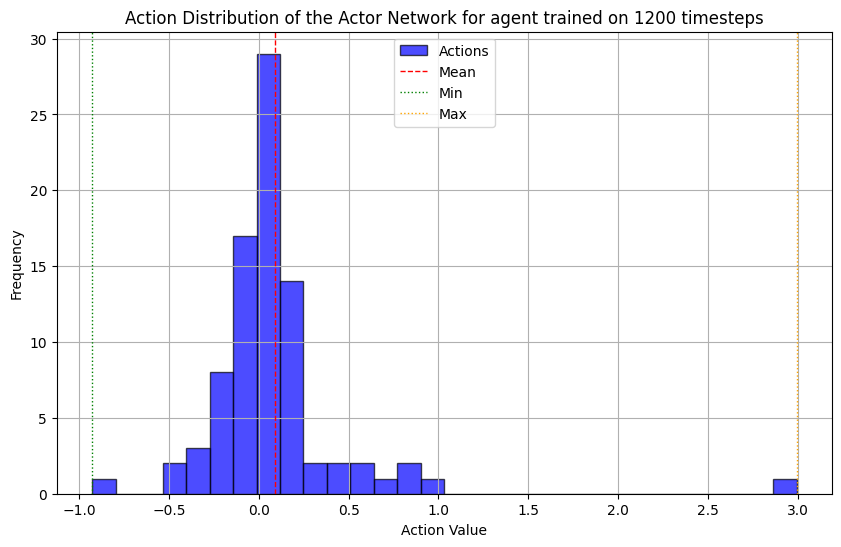

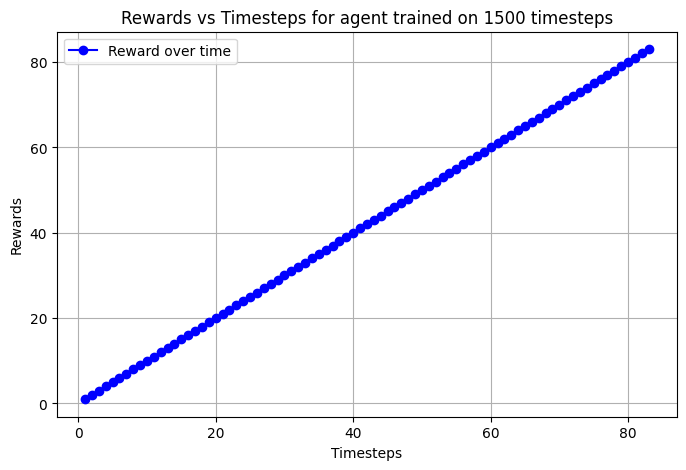

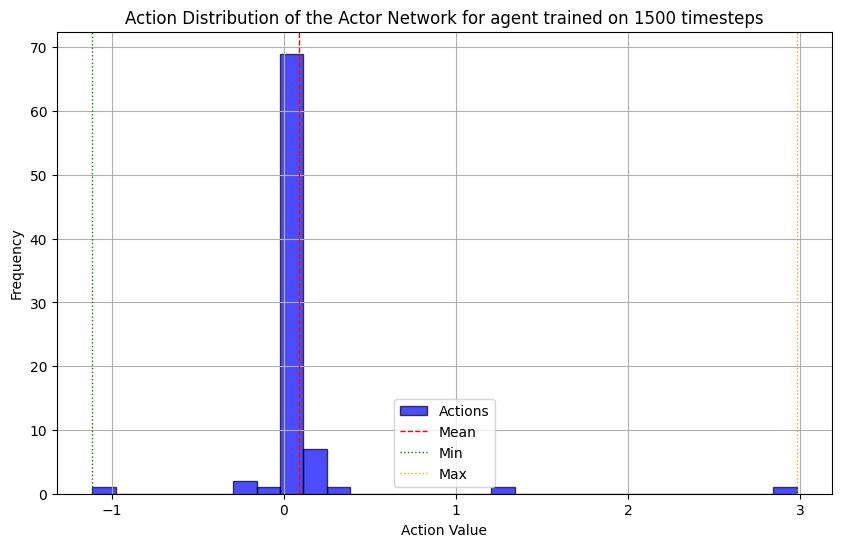

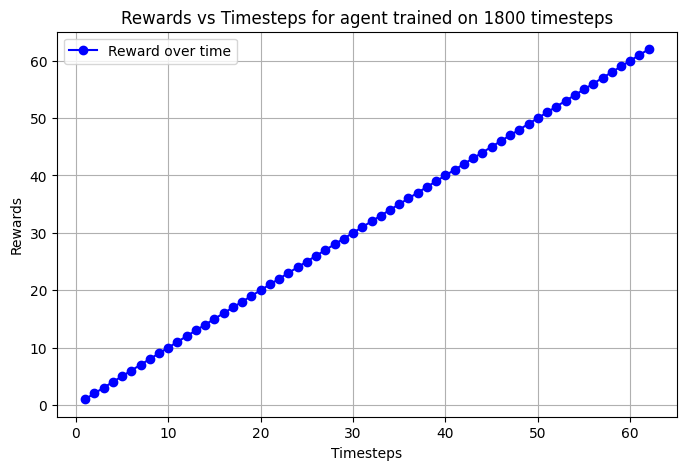

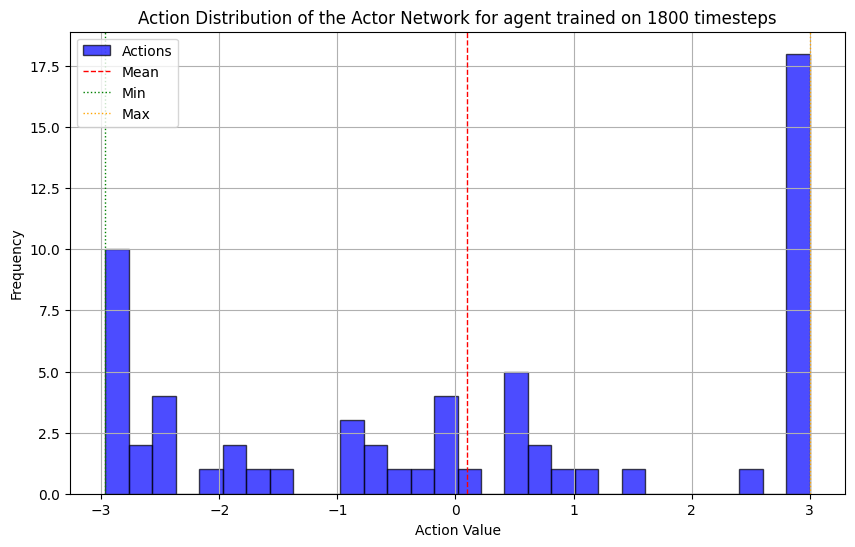

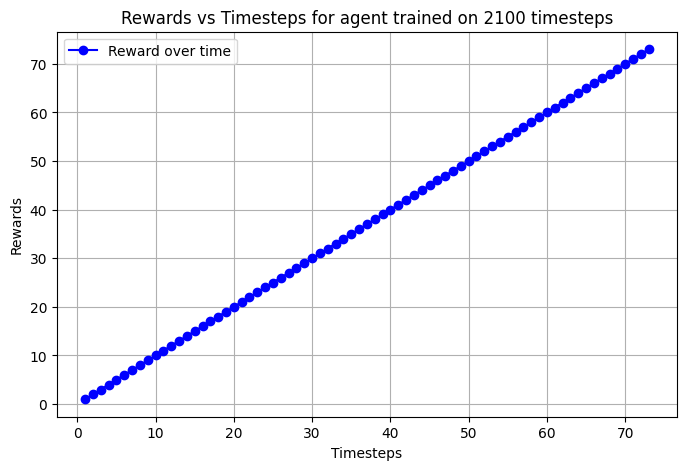

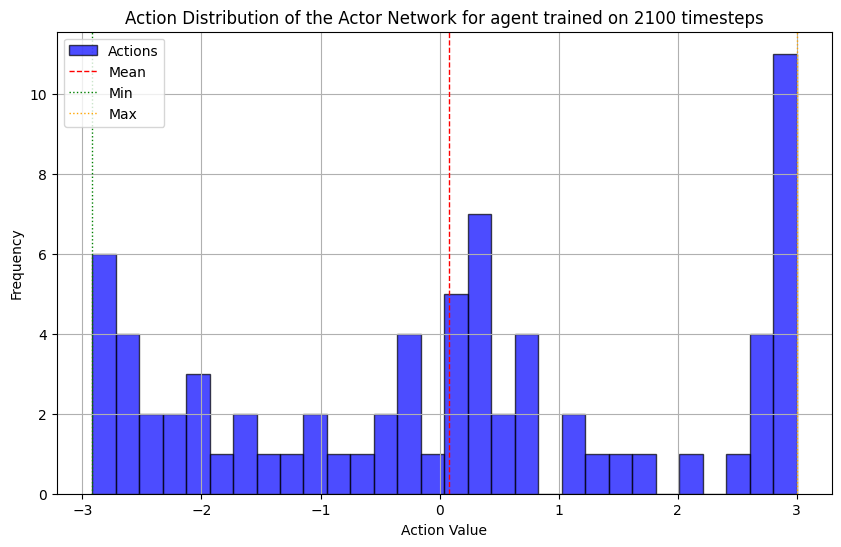

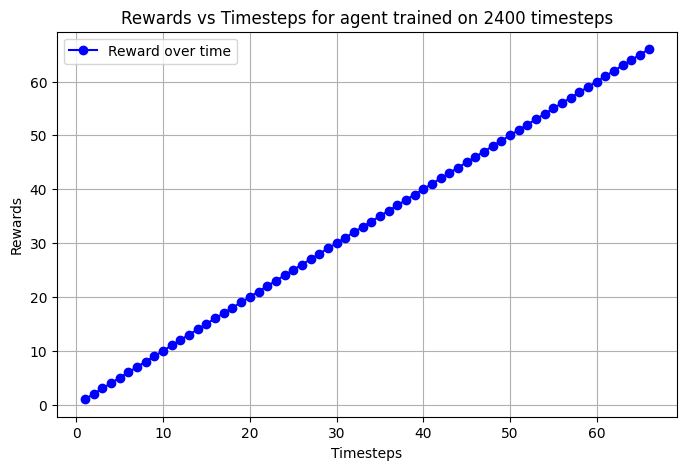

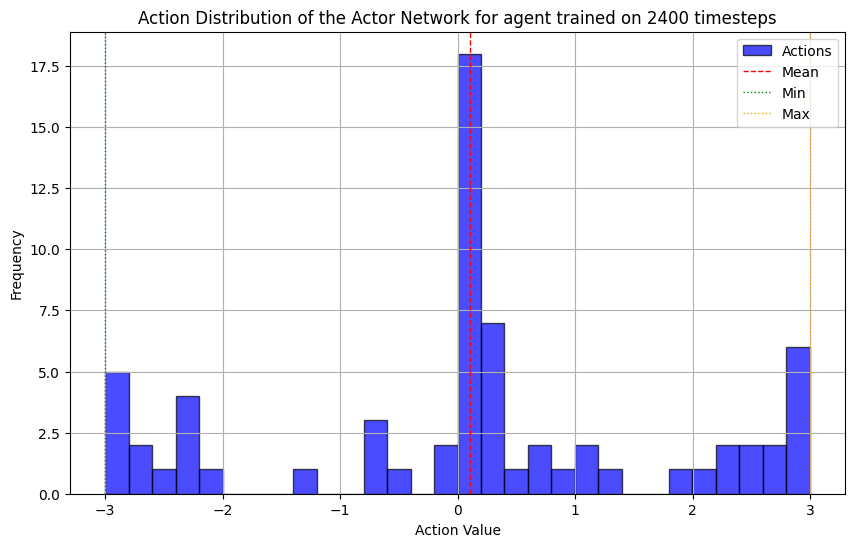

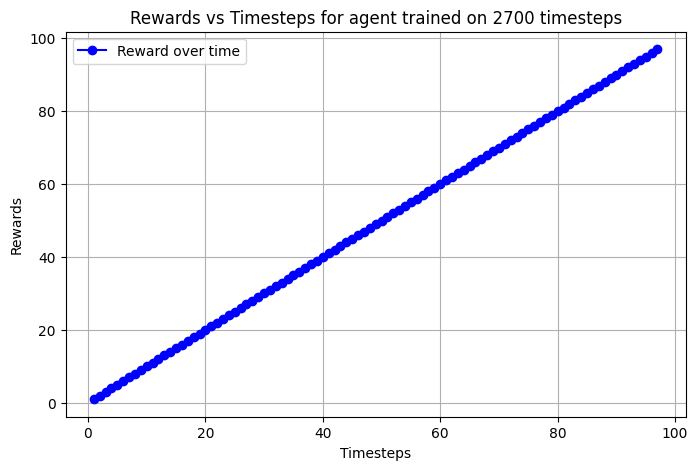

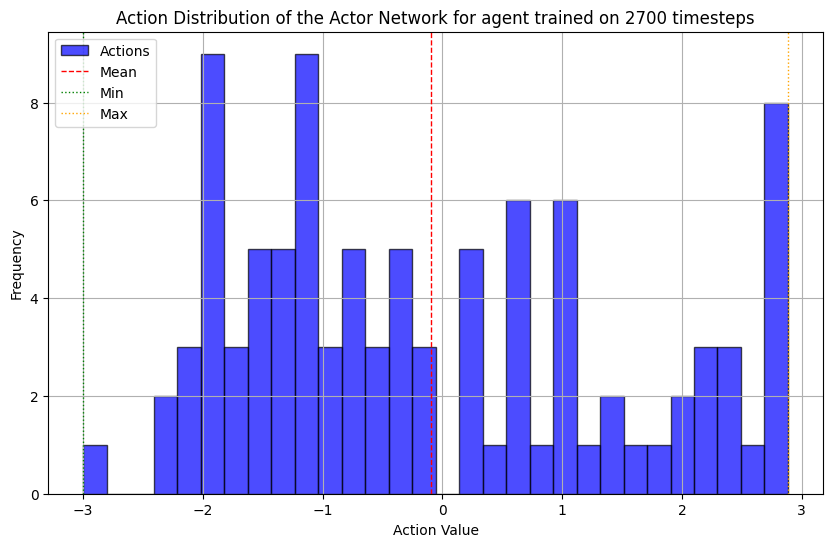

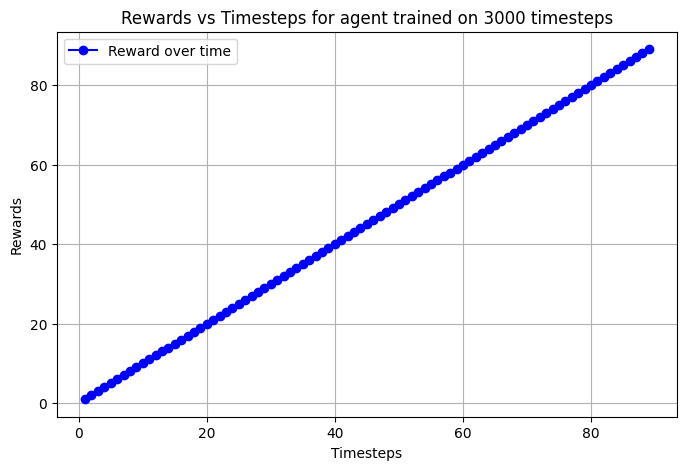

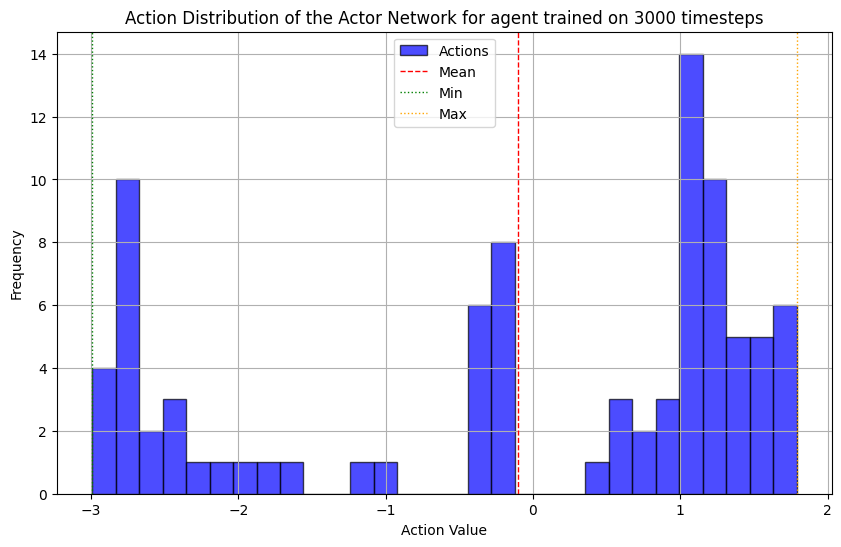

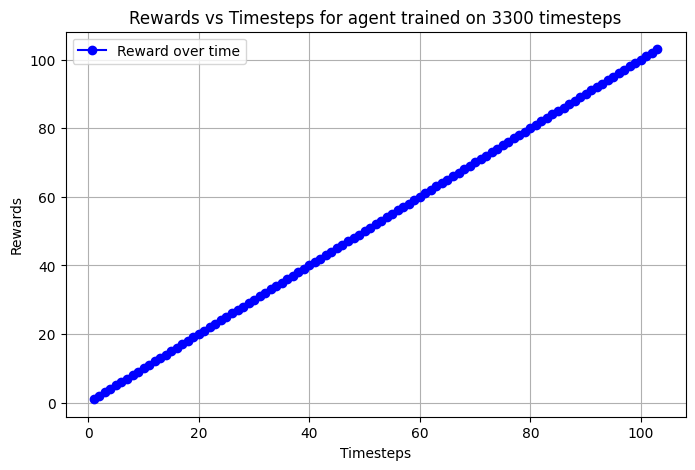

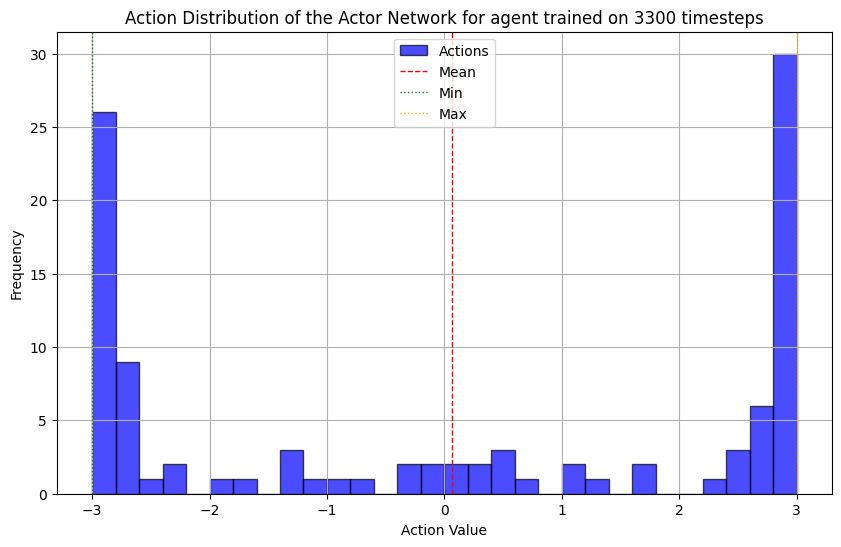

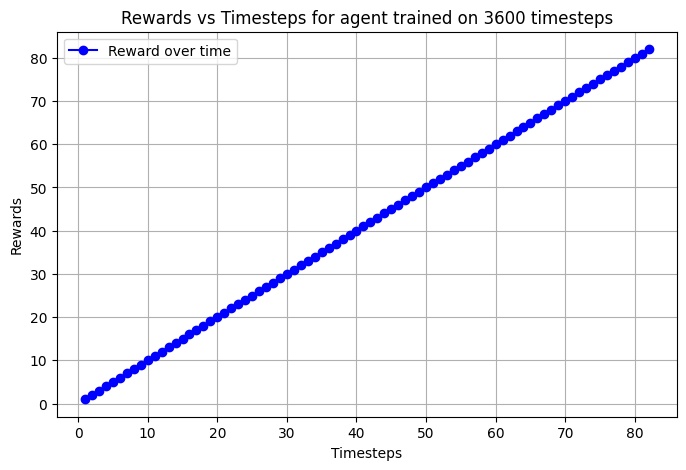

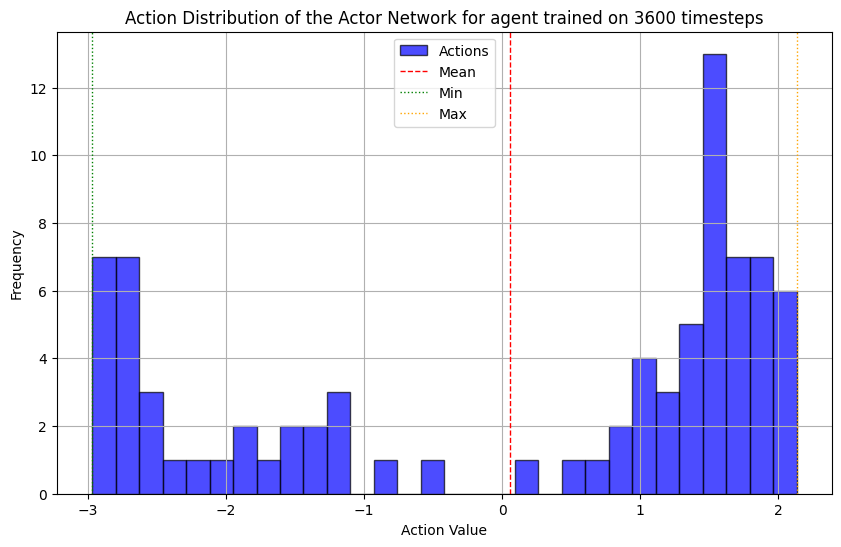

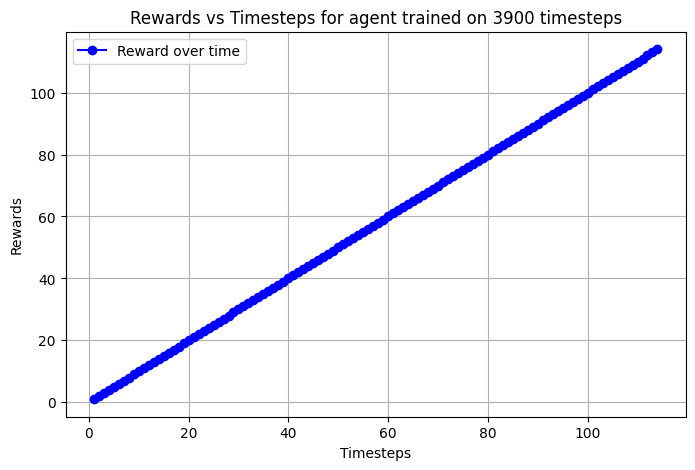

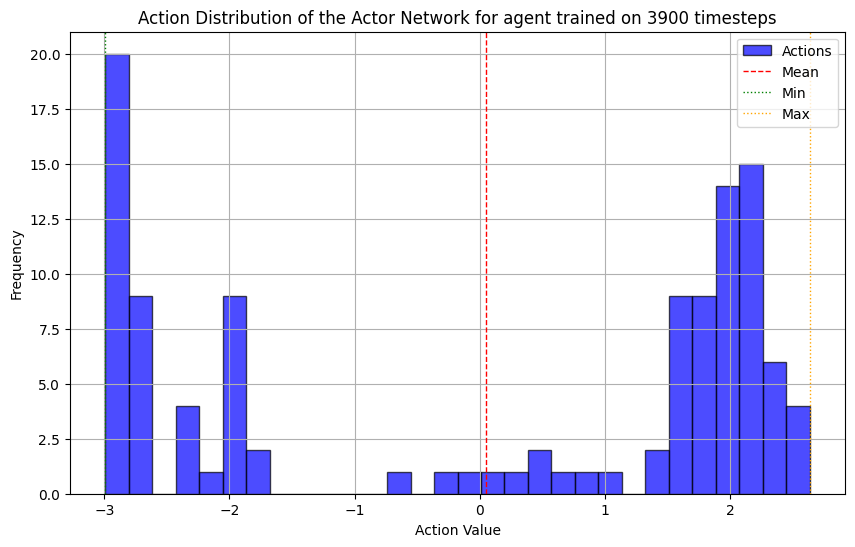

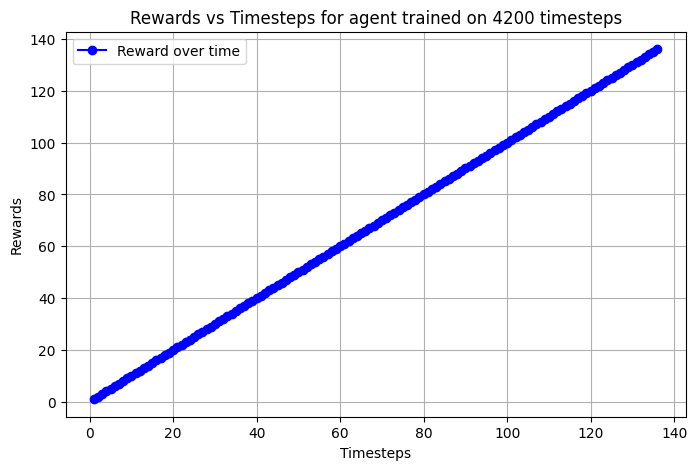

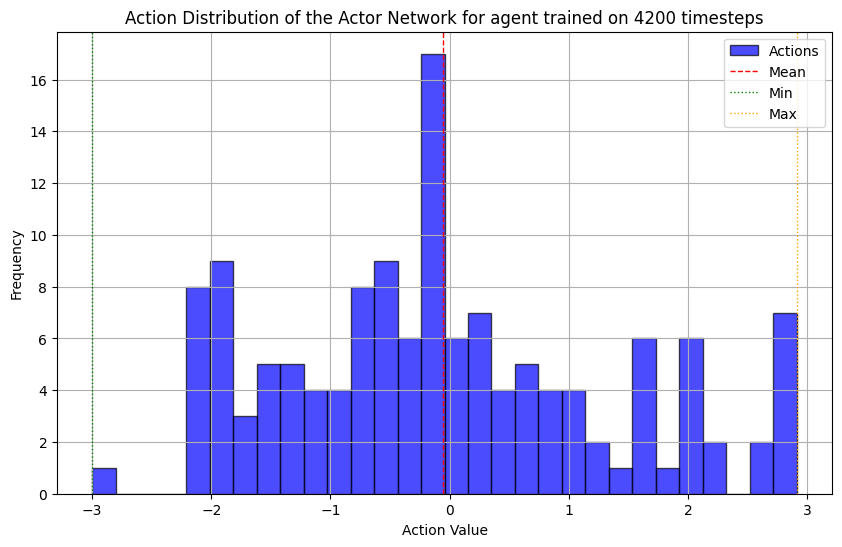

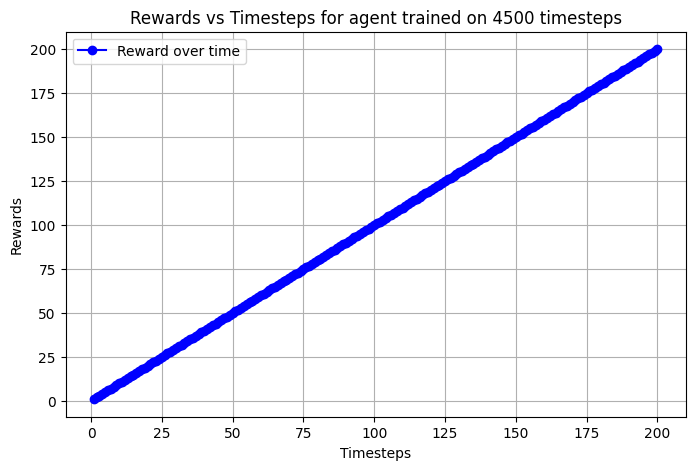

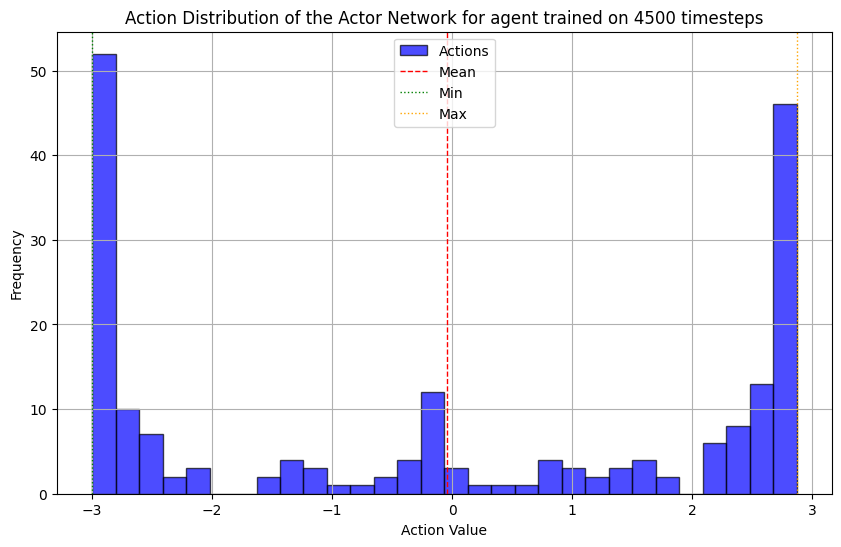

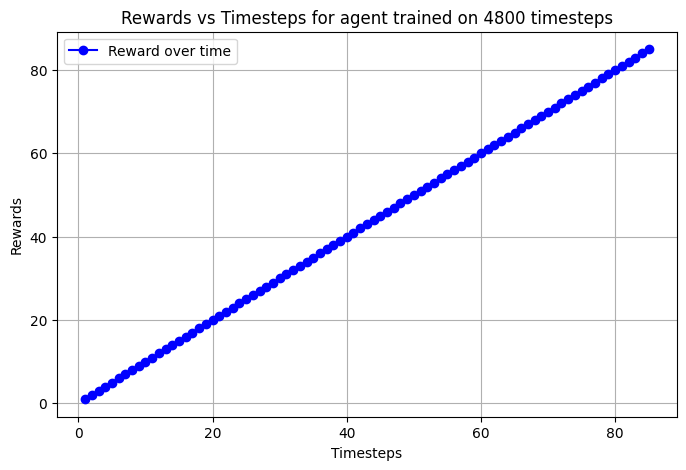

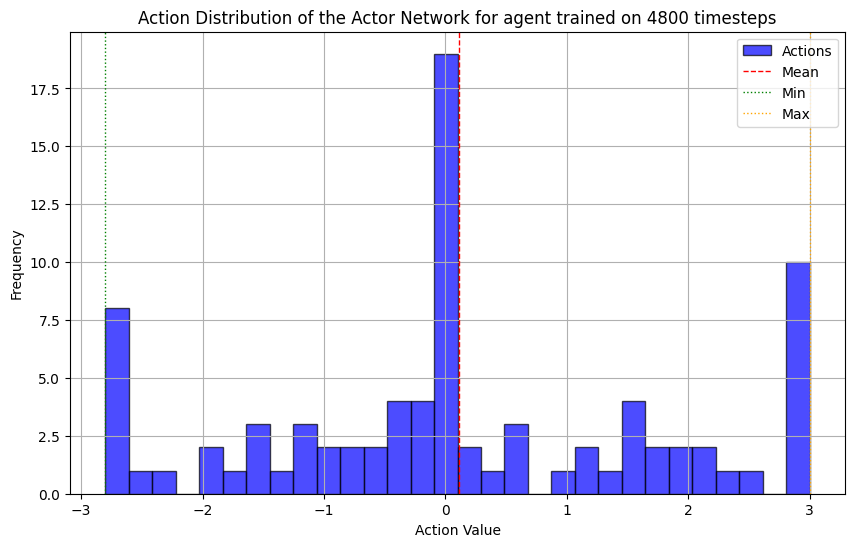

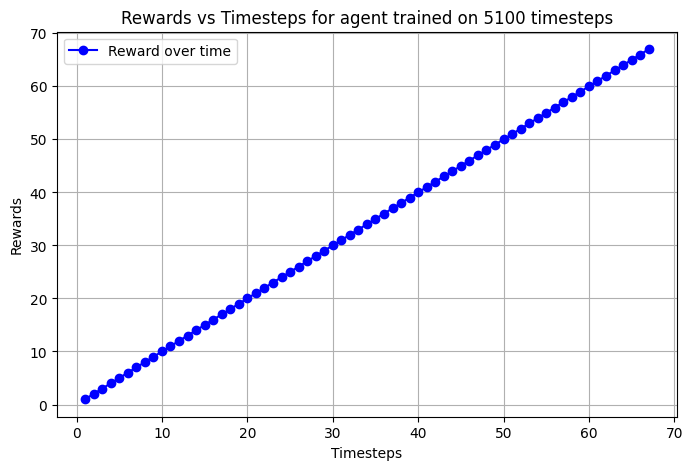

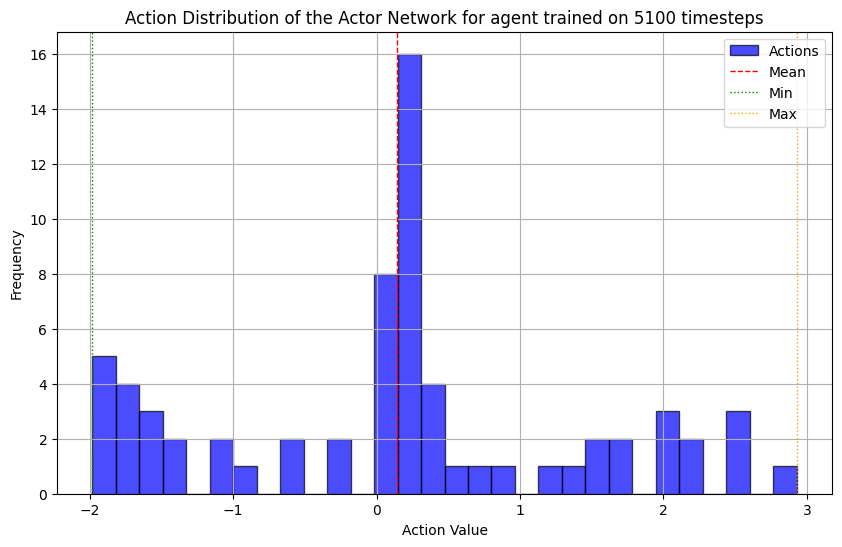

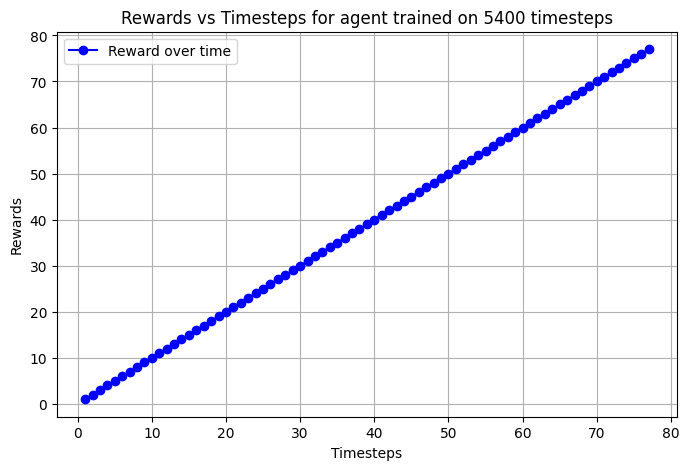

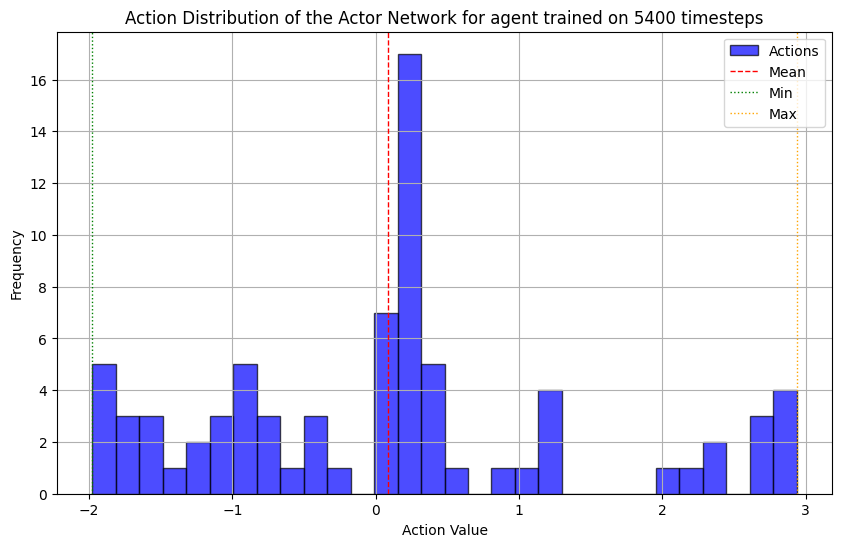

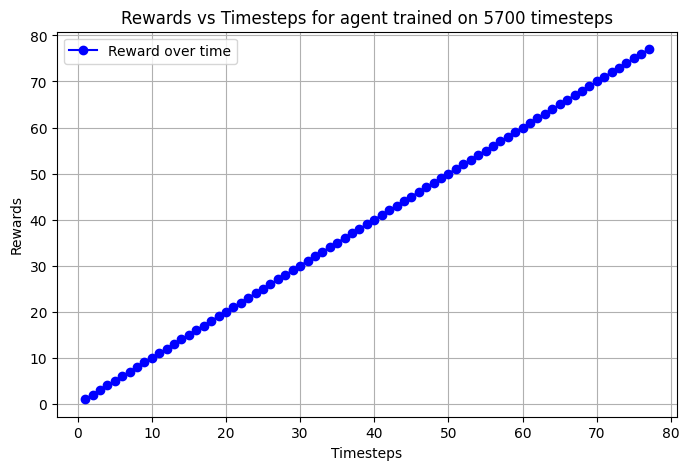

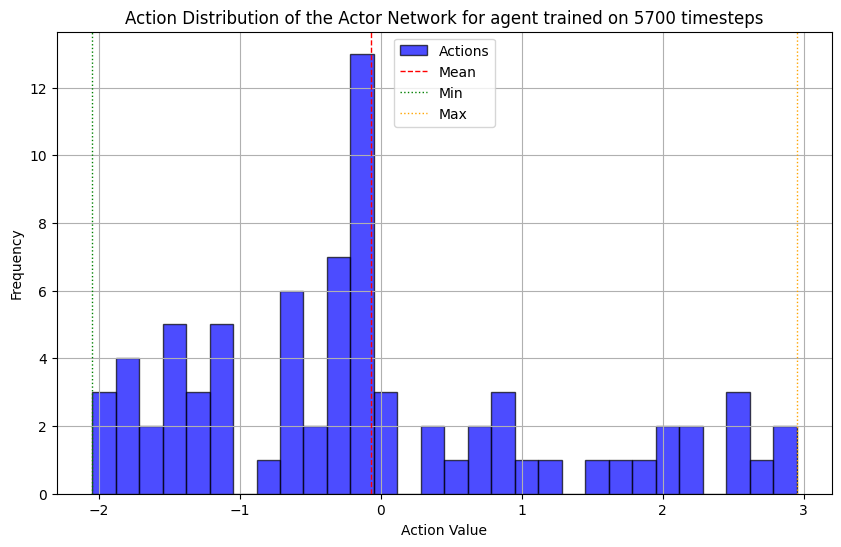

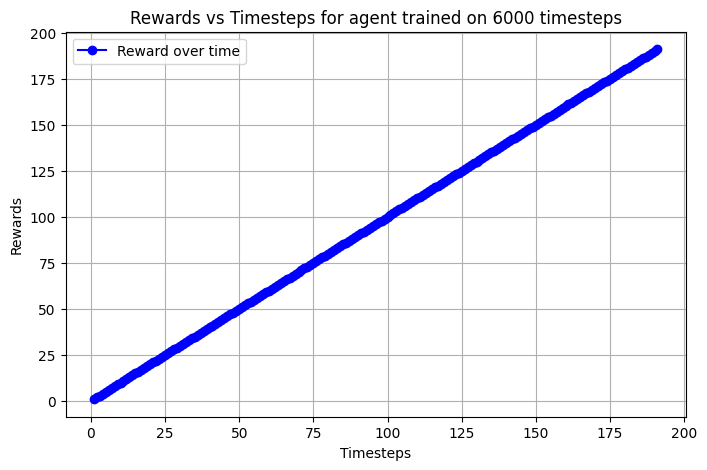

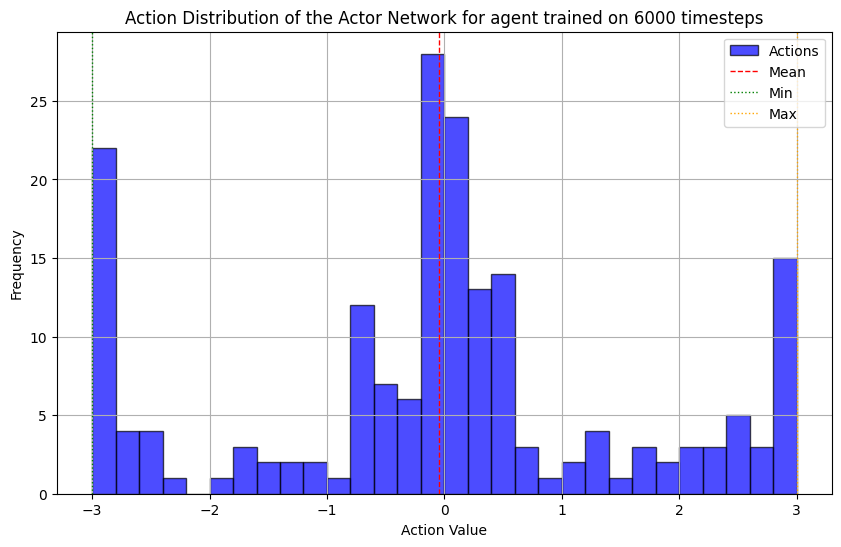

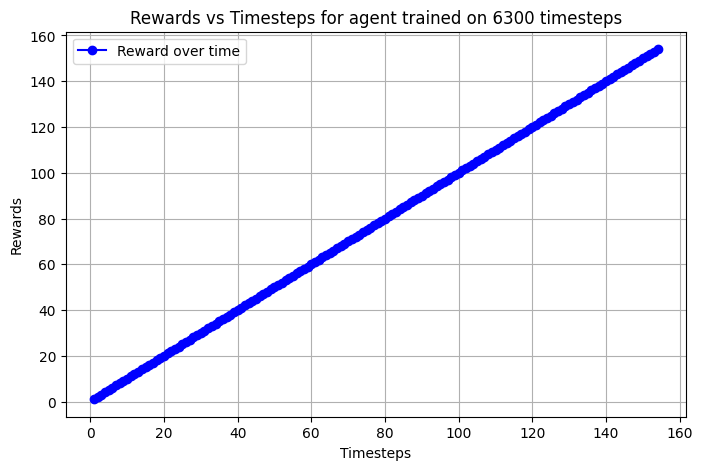

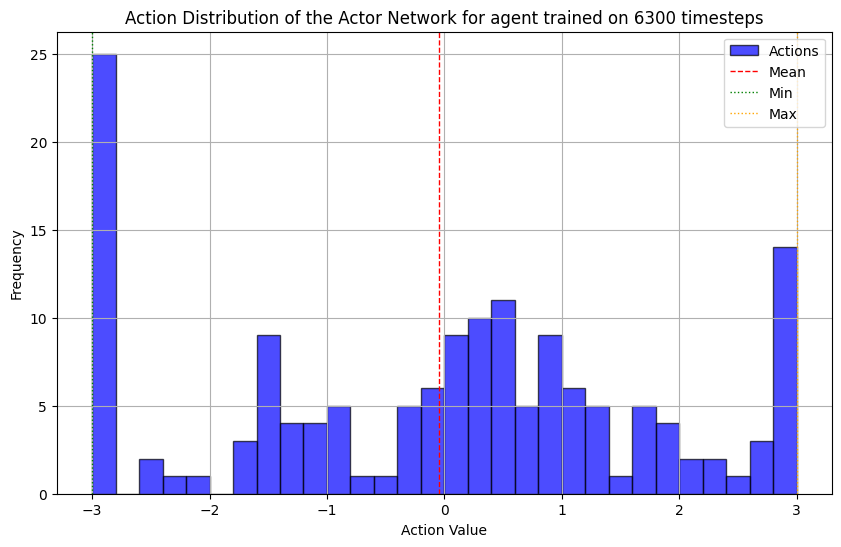

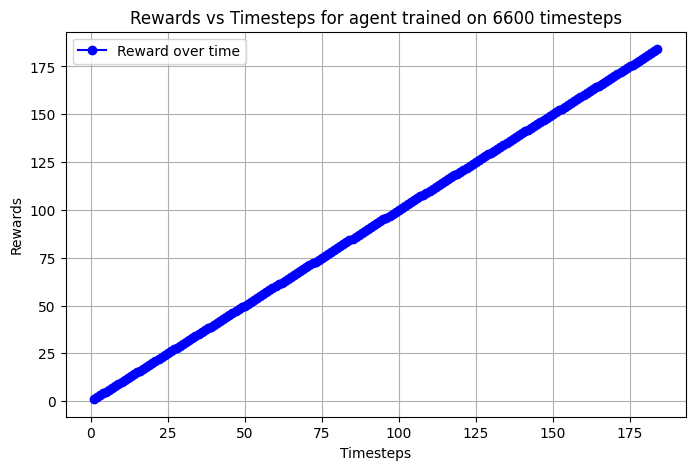

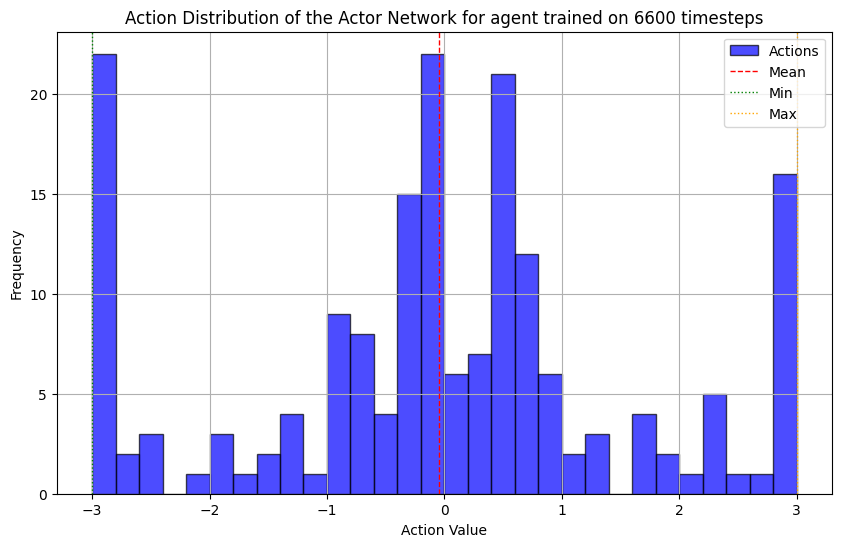

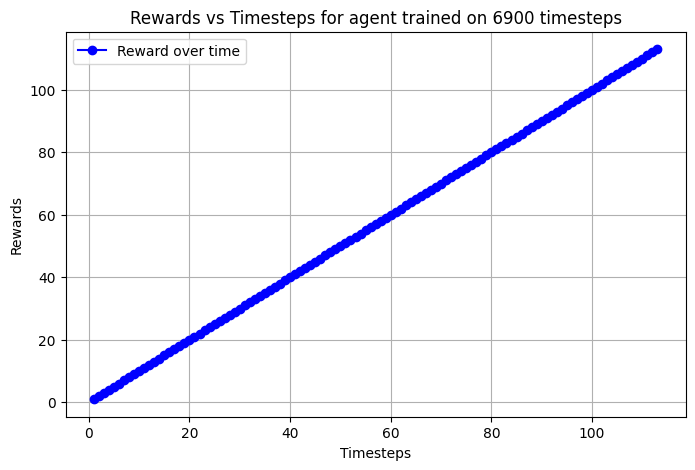

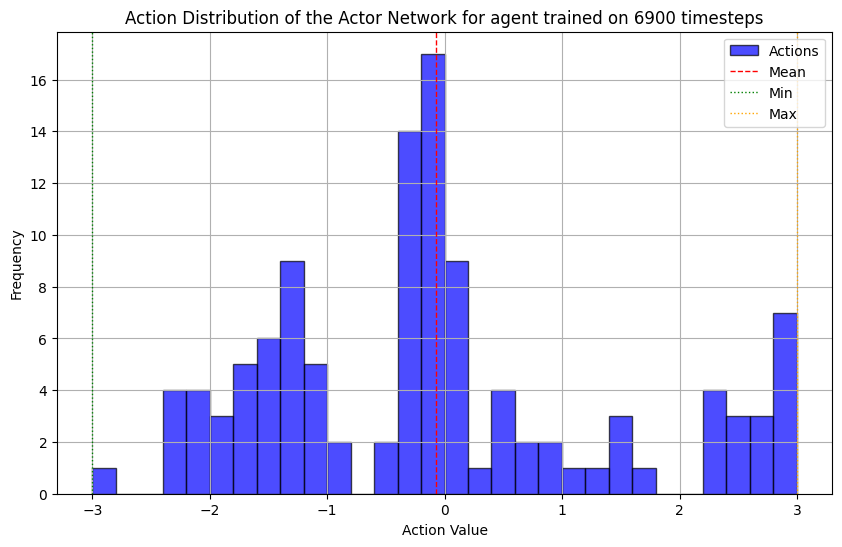

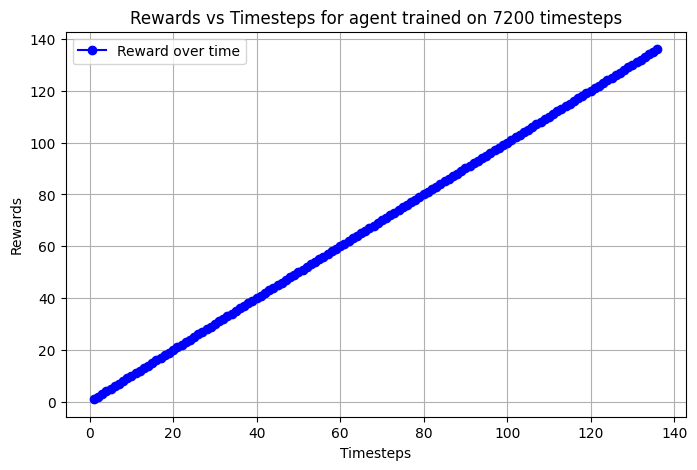

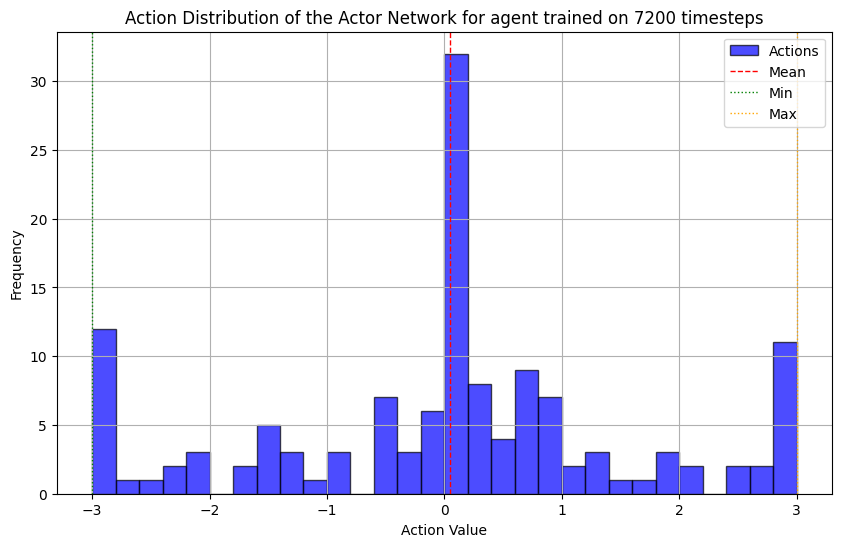

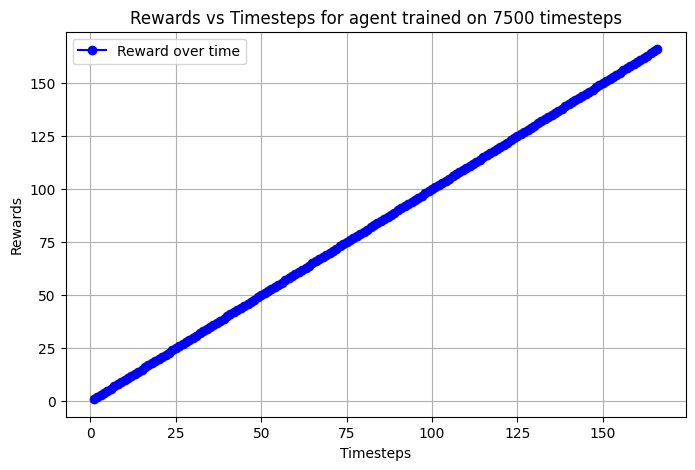

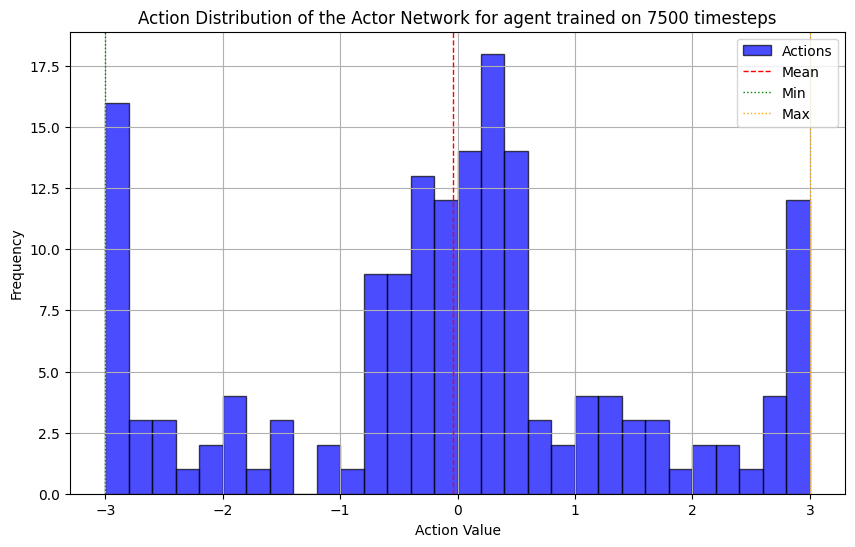

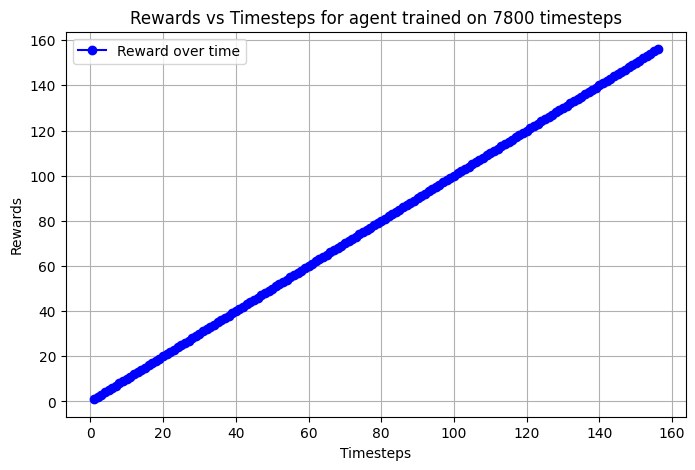

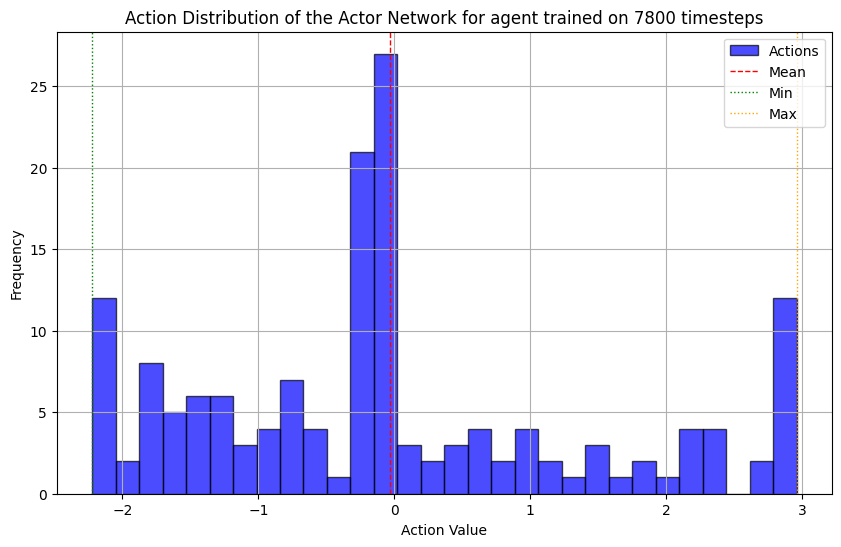

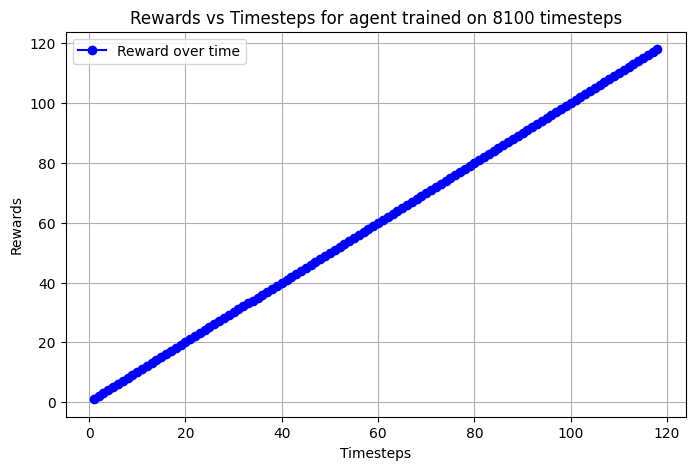

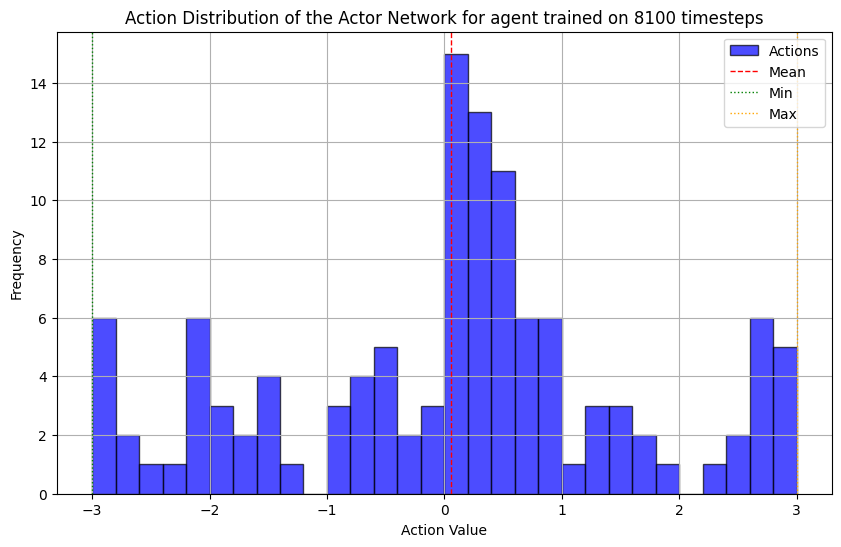

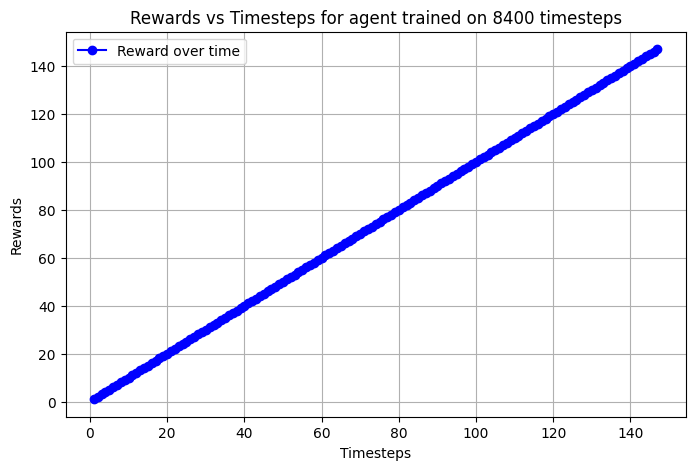

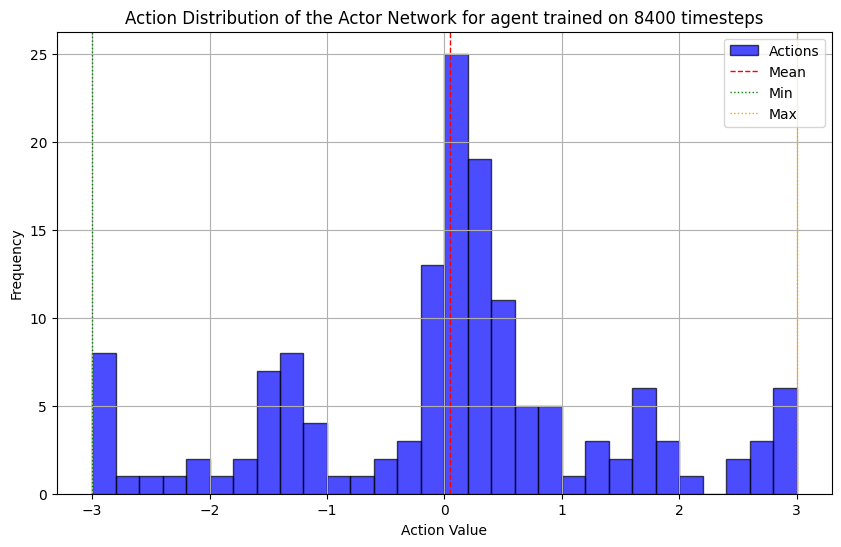

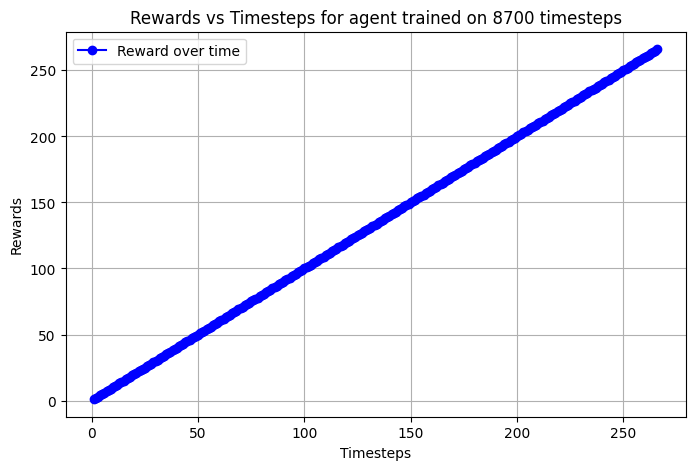

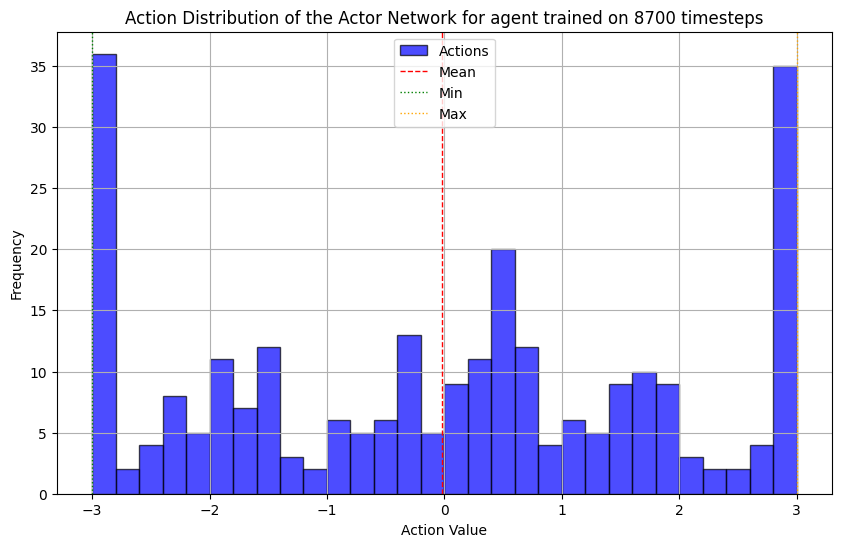

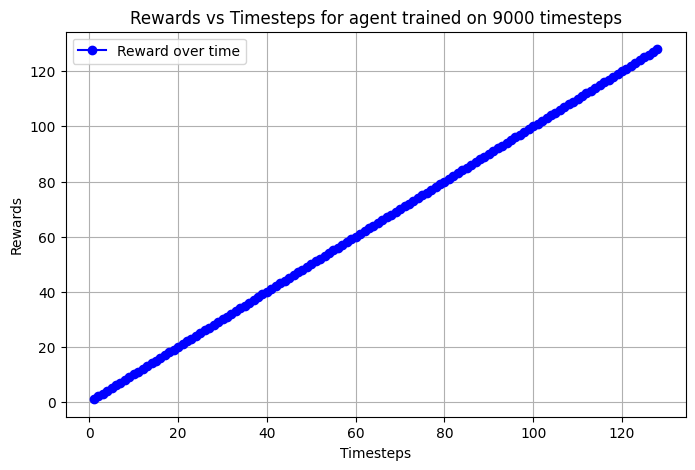

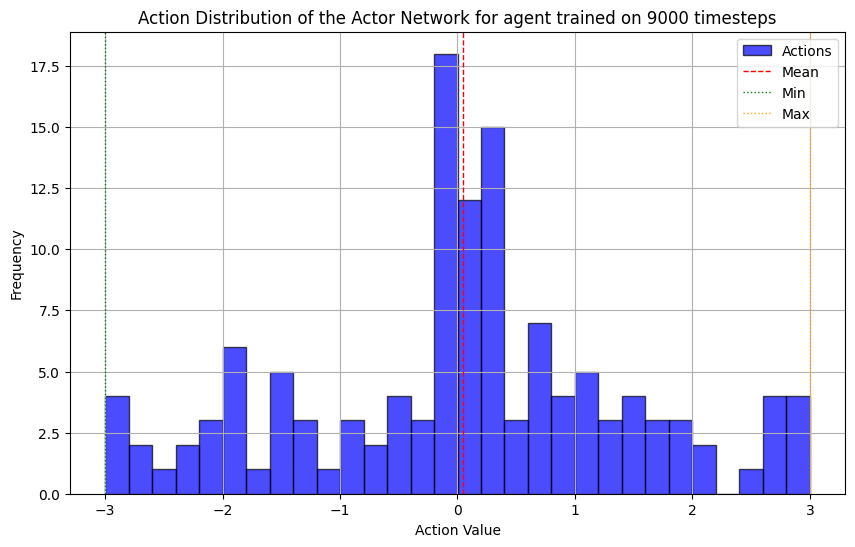

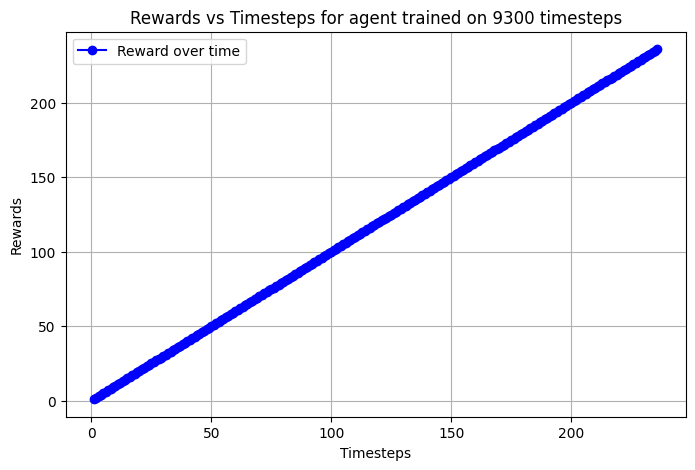

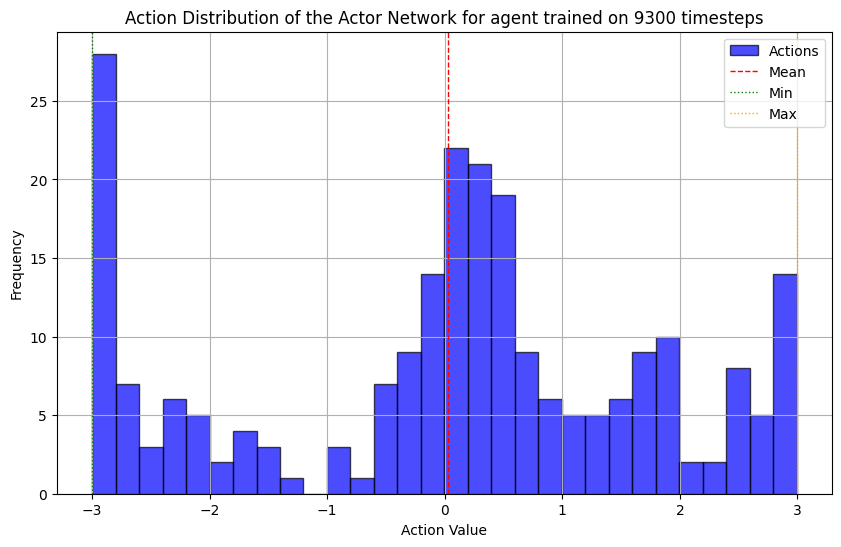

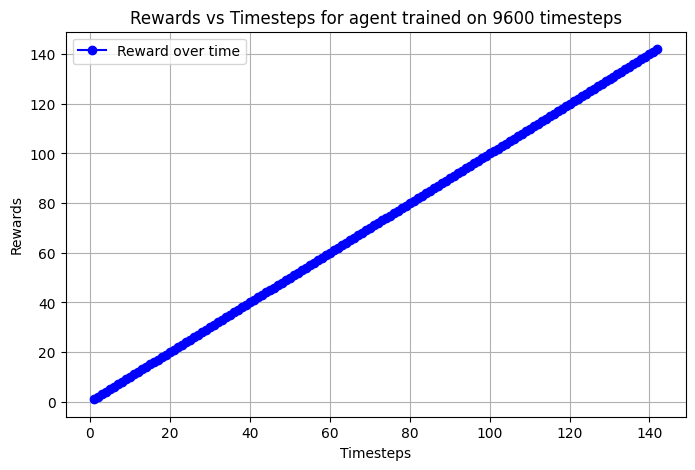

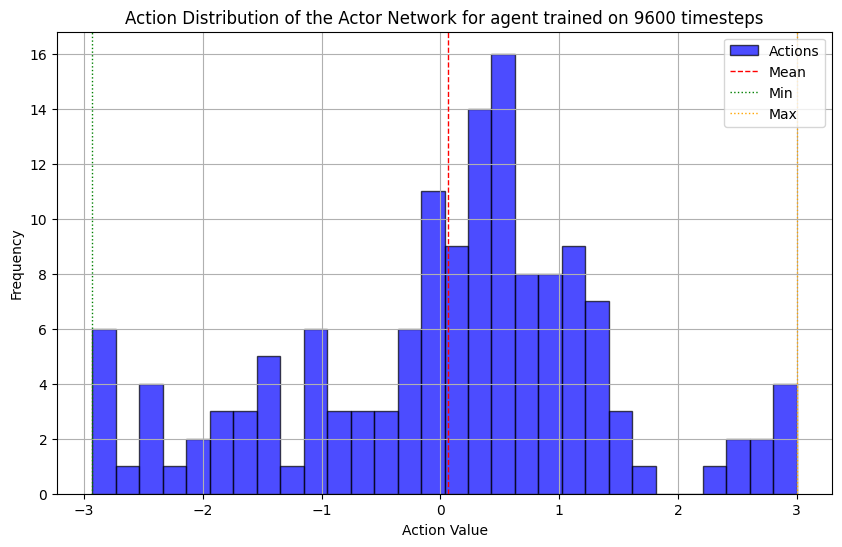

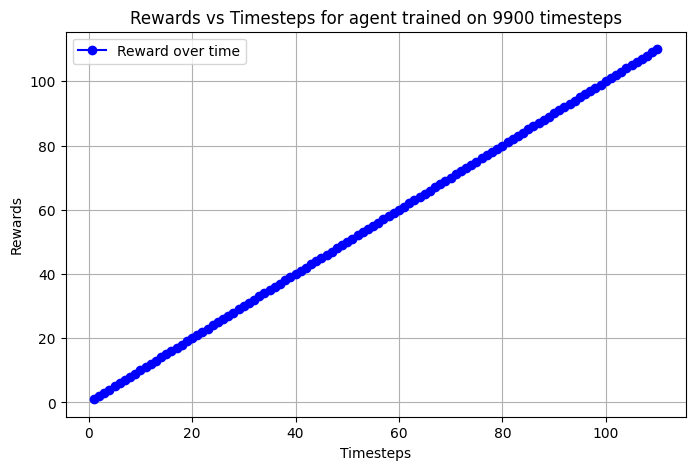

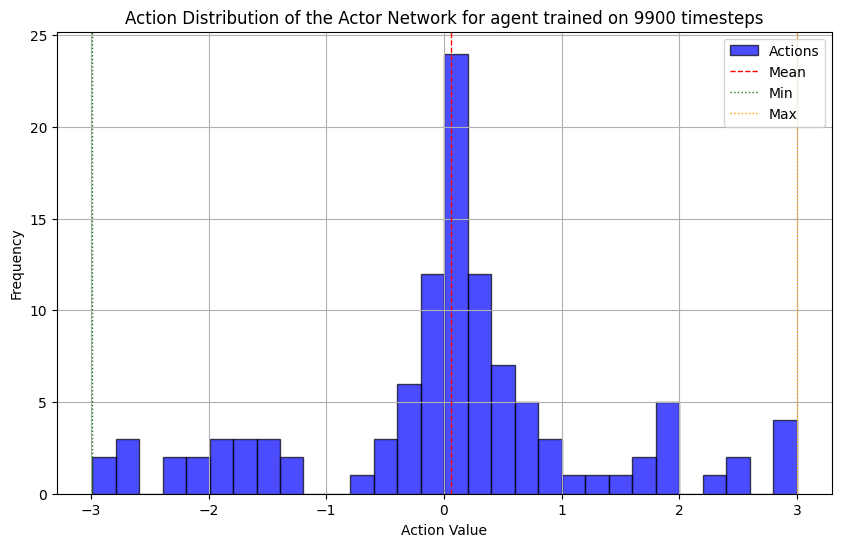

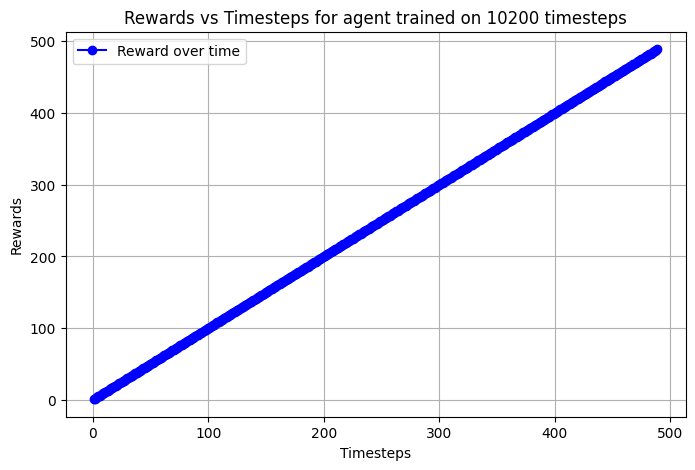

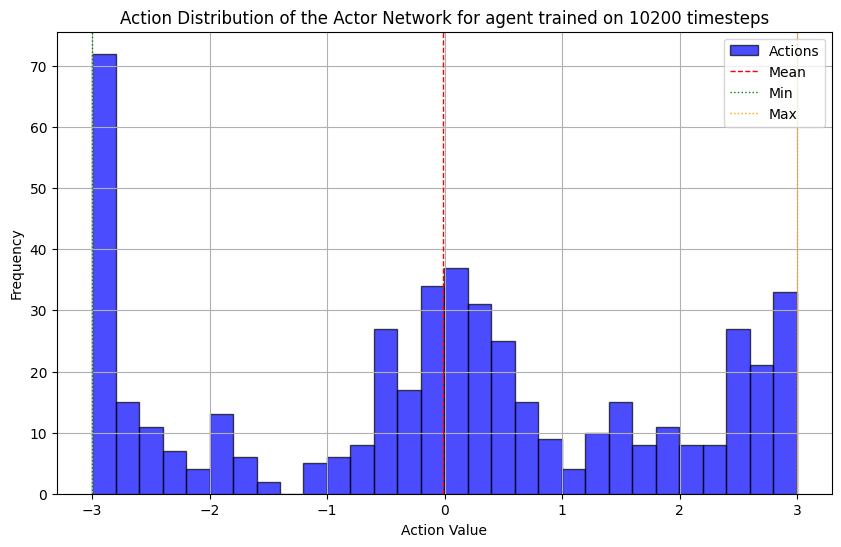

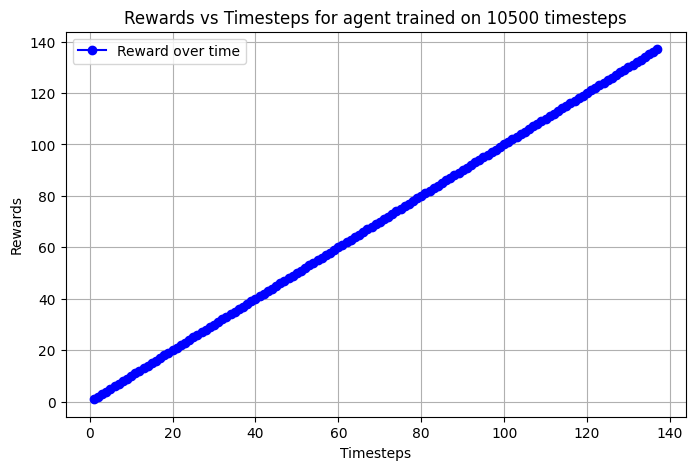

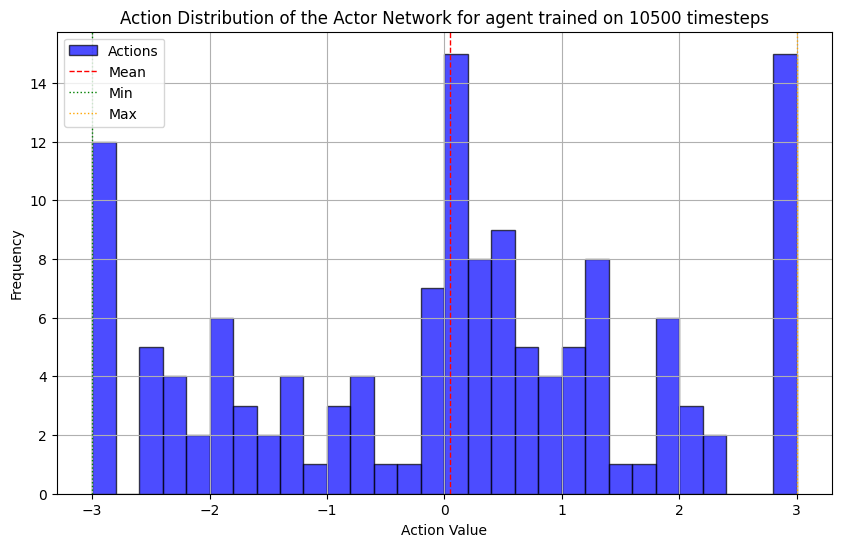

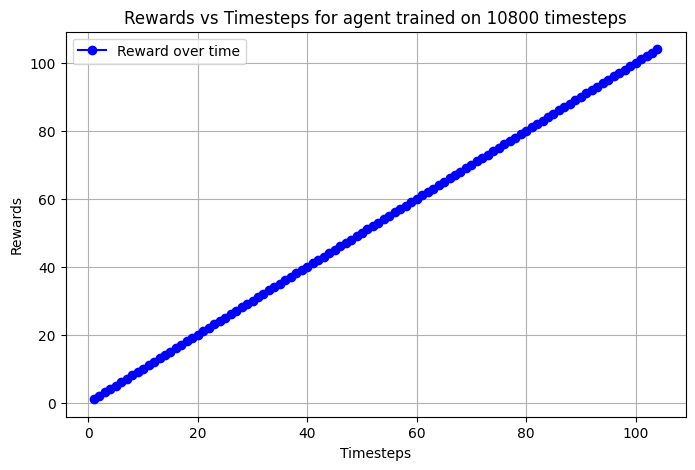

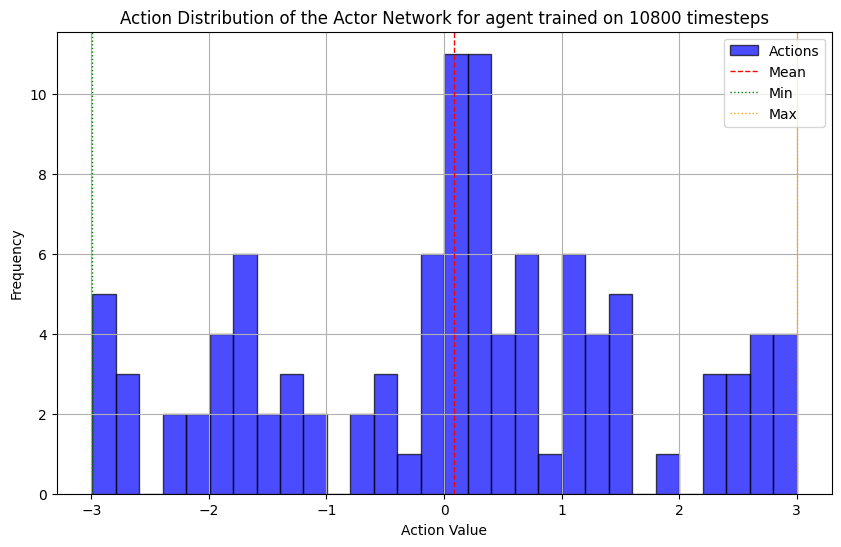

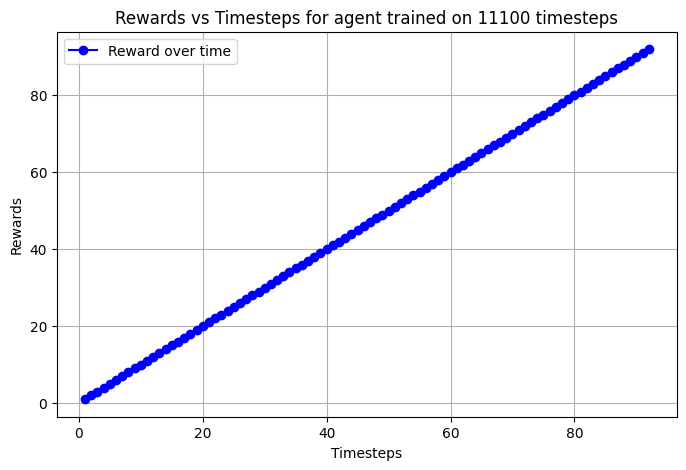

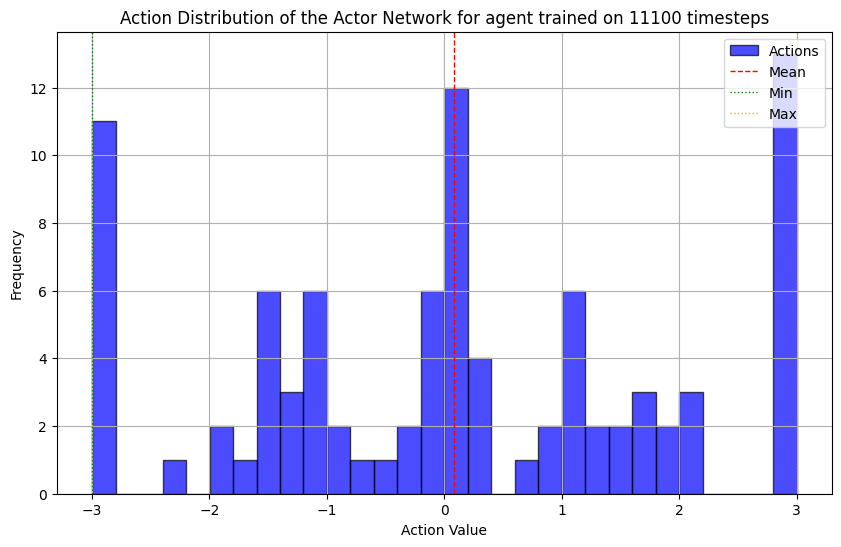

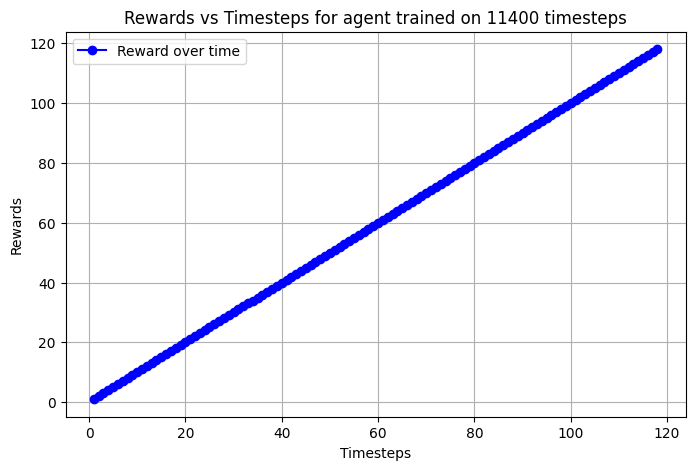

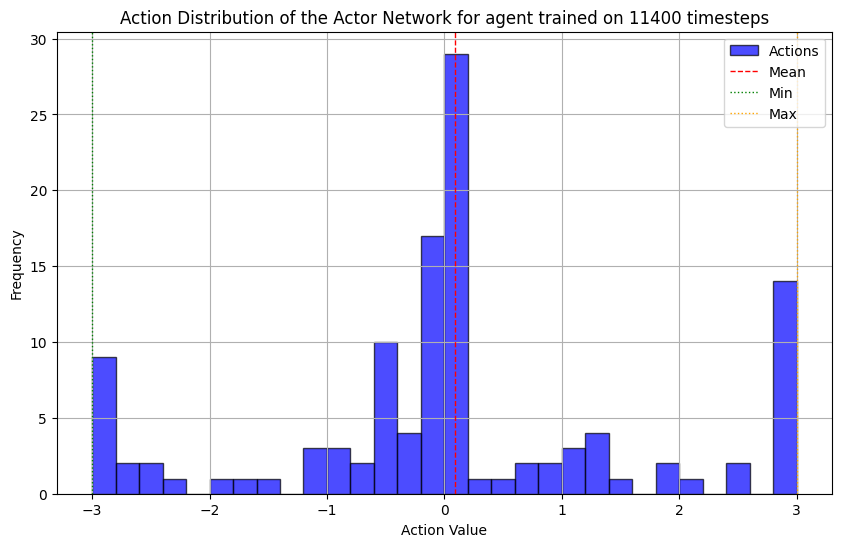

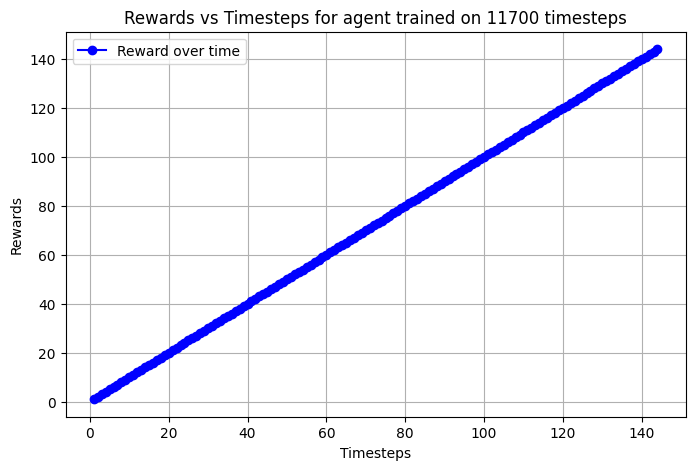

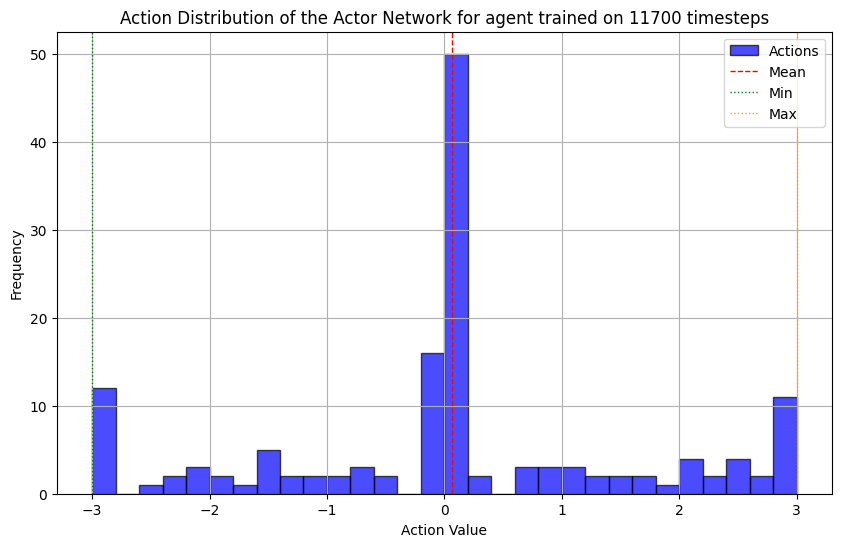

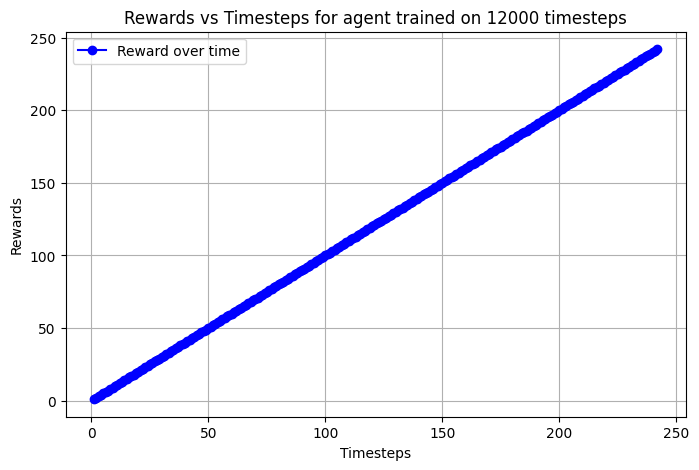

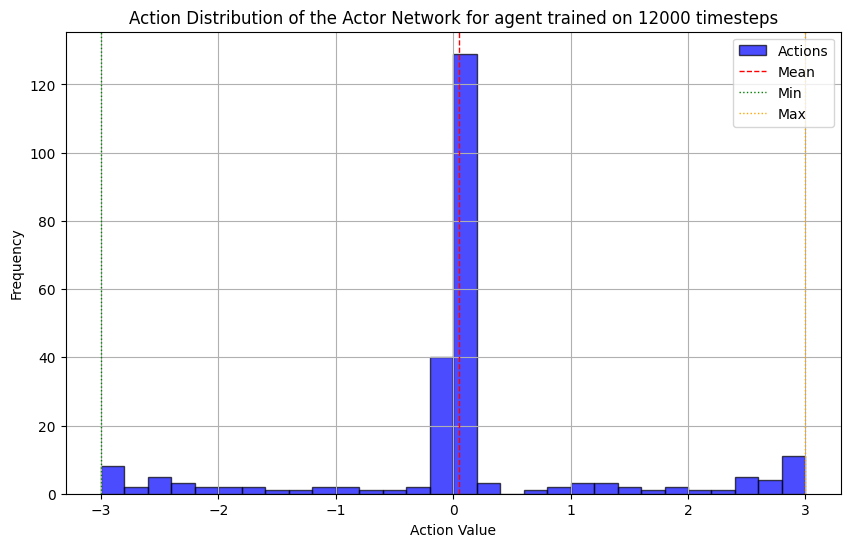

In [115]:
# Record videos for the highest-reward episodes for each training timestep
for y in models_saved:
    e = y
    timesteps = []
    reward_for_timestep = []
    rewards_count = 0
    if y in best_model_per_timestep and best_env_seed_per_timestep[y] is not None:
        env = gym.make("InvertedPendulum-v4", render_mode="rgb_array")

        if y % video_save_freq == 0:
            print(f"Recording video for the best episode with {y} timesteps (reward: {highest_reward_per_timestep[y]})")
            folder_path = f"videos/best/timesteps_{training}/timesteps_{y}/"
            os.makedirs(folder_path, exist_ok=True)
            env = RecordVideo(env, video_folder=folder_path, name_prefix="eval_best_run",episode_trigger=lambda e:e % video_save_freq == 0)
        obs, info = env.reset(seed=best_env_seed_per_timestep[y])  # Reset with the saved seed
        
        done = False
        while not done:
            action, _ = best_model_per_timestep[y].predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)
            rewards_count+= reward
            reward_for_timestep.append(rewards_count)

        env.close()

        #create rewards graph for each timestep
        # Create the plot
        timesteps = list(range(1, len(reward_for_timestep) + 1))
        plt.figure(figsize=(8, 5))  # Optional: set figure size
        plt.plot(timesteps, reward_for_timestep, marker='o', linestyle='-', color='b', label='Reward over time')
        
        # Add labels and title
        plt.xlabel('Timesteps')
        plt.ylabel('Rewards')
        plt.title(f'Rewards vs Timesteps for agent trained on {y} timesteps')
       
        plt.legend()  # Add legend
        plt.grid(True)  # Optional: add grid
        rewards_path = f"videos/best/timesteps_{training}/Rewards vs Timesteps for agent trained on {y} timesteps"
        os.makedirs(f"videos/best/timesteps_{training}/", exist_ok=True)
        plt.savefig(rewards_path, dpi=300)
        # Display the plot
        #plt.show()

        #create Action Distribution Figure
        plt.figure(figsize=(10, 6))
        plt.hist(best_actions[y], bins=30, alpha=0.7, color="blue", edgecolor="black", label="Actions")
        plt.axvline(best_actions[y].mean(), color="red", linestyle="dashed", linewidth=1, label="Mean")
        plt.axvline(best_actions[y].min(), color="green", linestyle="dotted", linewidth=1, label="Min")
        plt.axvline(best_actions[y].max(), color="orange", linestyle="dotted", linewidth=1, label="Max")
        plt.xlabel("Action Value")
        plt.ylabel("Frequency")
        plt.title(f"Action Distribution of the Actor Network for agent trained on {y} timesteps")
        plt.legend()
        plt.grid(True)
        action_path = f"videos/best/timesteps_{training}/Action Distribution for agent trained on {y} timesteps"
        os.makedirs(f"videos/best/timesteps_{training}/", exist_ok=True)
        plt.savefig(action_path, dpi=300)
        #plt.show()

#print(avg_rewards)
total_rewards = [sum(values) / len(values) for values in zip(*avg_rewards)]
total_std = np.std(avg_rewards, axis=0, ddof=1)

total_rewards = np.array(total_rewards,dtype=float)
total_std = np.array(total_std,dtype=float)
#print(total_rewards)
#print(total_std)
#print(best_actions)

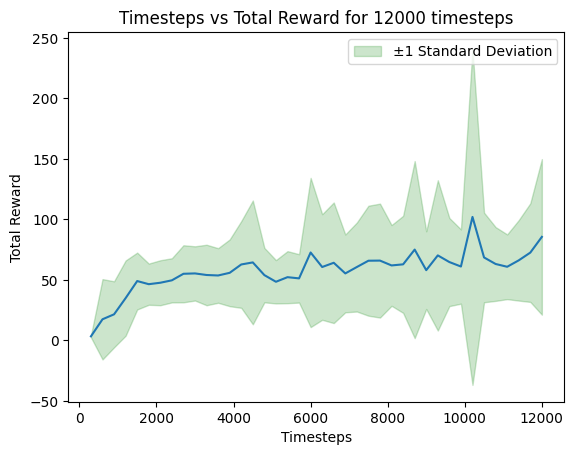

In [120]:
# Plot episode rewards
r = models_saved
plt.plot(r,total_rewards)
plt.fill_between(r,total_rewards - total_std, total_rewards + total_std,color='g', alpha=0.2, label='±1 Standard Deviation')
plt.xlabel("Timesteps")
plt.legend()
plt.ylabel("Total Reward")
plt.title(f"Timesteps vs Total Reward for {training} timesteps")
plt.savefig(f"videos/best/timesteps_{training}/Timestep vs Total Reward for {training}", dpi=300)
plt.show()